### Dose money make people happy?
- It takes around **50 mins** to run this whole jupyter

In [1]:
import re
import json
import emoji
import pyproj
import string
import imageio
import operator
import functools
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
from numpy import nan
from fiona.crs import from_epsg
from IPython.display import HTML
from shapely.ops import nearest_points
from shapely.geometry import Point, Polygon
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge, Lasso
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# We are going to use zip-level aggregated data for entire analysis
# Download raw zip data here: https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

NYCzip = gpd.read_file('Data/NY.shp')
NYCzip.head()

zipcode                                           geometry
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...
1  11004.0  POLYGON Z ((-73.71068374074007 40.750040394509...
2  11040.0  POLYGON Z ((-73.70098278625547 40.738895699230...
3  11426.0  POLYGON Z ((-73.72270447144122 40.753733714383...
4  11365.0  POLYGON Z ((-73.81088634744755 40.727171875759...

# 1. Data Preprocessing

### 1.1 Import Tweets (Crawled from 2018-10-25 to 2018-11-26)

In [8]:
# Crawl geo-tagged tweets through twitter API from 2018-10-25 to 2018-11-26. 
# We only save (id, content, location, time) information for every tweet

tweets = json.load(open('Data/102420_112619_424000.json', 'r'))
tweets_dict = {'tweet_id': [], 'content': [], 'coordinates': [], 'lon': [], 'lat': [], 'time': []}
for key in tweets.keys():
    tweets_dict['tweet_id'].append(key)
    tweets_dict['content'].append(tweets[key]['text'])
    tweets_dict['lon'].append(tweets[key]['coordinates']['coordinates'][0])
    tweets_dict['lat'].append(tweets[key]['coordinates']['coordinates'][1])
    tweets_dict['coordinates'].append(tweets[key]['coordinates']['coordinates'])
    tweets_dict['time'].append(tweets[key]['time'])
tweets_pd = pd.DataFrame(tweets_dict)

In [9]:
tweets_pd.head()

content  \
0  𝗗𝗜𝗚𝗜𝗧𝗔𝗟 𝗔𝗥𝗧𝗭 🦄𝗧𝗢 𝗖𝗔𝗡𝗩𝗔𝗦 \n🖼🖼🖼🖼🖼🖼🖼🖼🖼🖼🖼🖼🖼\n(𝗸)𝗿𝗲...   
1  WANTED: Mac book 2011 (11207) @ https://t.co/b...   
2  I'm listening to 1st Of The Month by Bone Thug...   
3  Heading back to Florida! (@ Westchester County...   
4  Incident on #1Line Manhattan bound from 137th ...   

                  coordinates                 time             tweet_id  
0   [-73.9934863, 40.7524086]  2018-11-09 15:40:54  1060920170401722370  
1   [-73.8918897, 40.6655101]  2018-10-29 14:53:45  1056922037275504640  
2     [-73.501627, 40.810473]  2018-11-05 18:07:11  1059507434950135808  
3  [-73.7040901, 41.06868247]  2018-11-26 20:13:17  1067149311731994631  
4      [-73.95407, 40.821338]  2018-11-03 12:23:27  1058696154362339329

In [10]:
tweets_pd.shape

(424000, 6)

In [11]:
tweets_pd.describe()

lat            lon
count  424000.000000  424000.000000
mean       40.903148     -74.025394
std         0.729039       1.932830
min       -29.994661    -122.542674
25%        40.714200     -74.006400
50%        40.739542     -73.983224
75%        40.797879     -73.900486
max        55.902815     139.992625

### 1.2 Select NYC's tweets by limiting range of (lat, lon)

In [12]:
# -74.256, -73.699
# 40.495, 40.915
# This range was infered by NYCzip data

ind = (tweets_pd.lon > -74.256) & (tweets_pd.lon < -73.699) & (tweets_pd.lat > 40.495) & (tweets_pd.lat < 40.915)
sum(ind), sum(ind) / len(tweets_pd) * 100

(317180, 74.8066037735849)

In [13]:
tweets_pd = tweets_pd.loc[ind]
tweets_pd.shape

(317180, 6)

### 1.3 Converting dataframe to a Geodaraframe

In [14]:
tweets_pd.head()

content              coordinates  \
0  Cleared: Incident on #M34ABus WB at 43 St betw...  [-73.989225, 40.757878]   
1  Get your tickets today @karsheen_azeem bio! @ ...          [-73.95, 40.65]   
2  Just posted a photo @ Montezuma Restaurant htt...    [-73.90185, 40.86868]   
3  #Repost from wrastudiodesign \n・・・\ndarren6_ev...          [-73.95, 40.65]   
4  I'm at Delta Flight: LGA to FLL in Queens, NY ...  [-73.862126, 40.769673]   

         lat        lon                 time             tweet_id  
0  40.757878 -73.989225  2018-10-28 21:57:37  1056666322212450304  
1  40.650000 -73.950000  2018-11-14 15:05:32  1062723210494394368  
2  40.868680 -73.901850  2018-10-27 03:22:41  1056023353037873153  
3  40.650000 -73.950000  2018-10-28 22:41:35  1056677384961830912  
4  40.769673 -73.862126  2018-10-25 19:53:16  1055547864955396096

In [15]:
tweets_pd['geometry'] = tweets_pd[['coordinates']].applymap(lambda x:Point(x))

In [16]:
tweets_pd = gpd.GeoDataFrame(tweets_pd)
tweets_pd.crs = from_epsg(code=4326)
tweets_pd.crs

{'init': 'epsg:4326', 'no_defs': True}

In [17]:
tweets_pd.head()

content              coordinates  \
0  Cleared: Incident on #M34ABus WB at 43 St betw...  [-73.989225, 40.757878]   
1  Get your tickets today @karsheen_azeem bio! @ ...          [-73.95, 40.65]   
2  Just posted a photo @ Montezuma Restaurant htt...    [-73.90185, 40.86868]   
3  #Repost from wrastudiodesign \n・・・\ndarren6_ev...          [-73.95, 40.65]   
4  I'm at Delta Flight: LGA to FLL in Queens, NY ...  [-73.862126, 40.769673]   

         lat        lon                 time             tweet_id  \
0  40.757878 -73.989225  2018-10-28 21:57:37  1056666322212450304   
1  40.650000 -73.950000  2018-11-14 15:05:32  1062723210494394368   
2  40.868680 -73.901850  2018-10-27 03:22:41  1056023353037873153   
3  40.650000 -73.950000  2018-10-28 22:41:35  1056677384961830912   
4  40.769673 -73.862126  2018-10-25 19:53:16  1055547864955396096   

                       geometry  
0  POINT (-73.989225 40.757878)  
1          POINT (-73.95 40.65)  
2    POINT (-73.90185 40.86868)  
3          POINT (-73.95 40.65)  
4  POINT (-73.862126 40.769673)

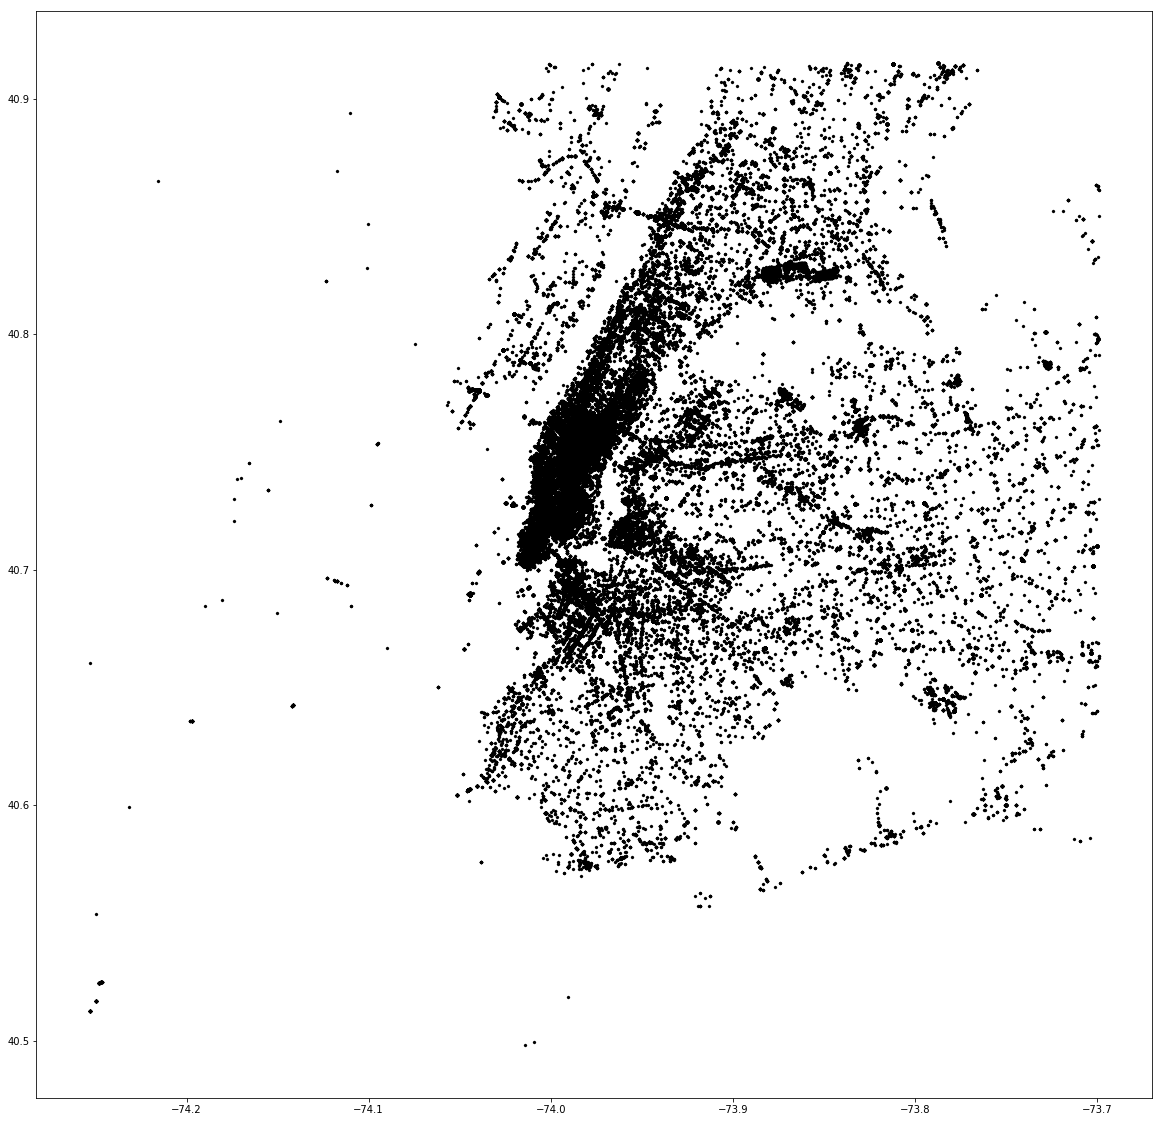

In [13]:
f = plt.figure(figsize=(20, 20))
ax = f.add_subplot(111)
tweets_pd.plot(column=None, color="black", linewidth=0.1, markersize=10, ax=ax)

#### Figure 1: Geo-tweets located within limited range

### 1.4 'Sjoin' NYCzip with tweets and plot

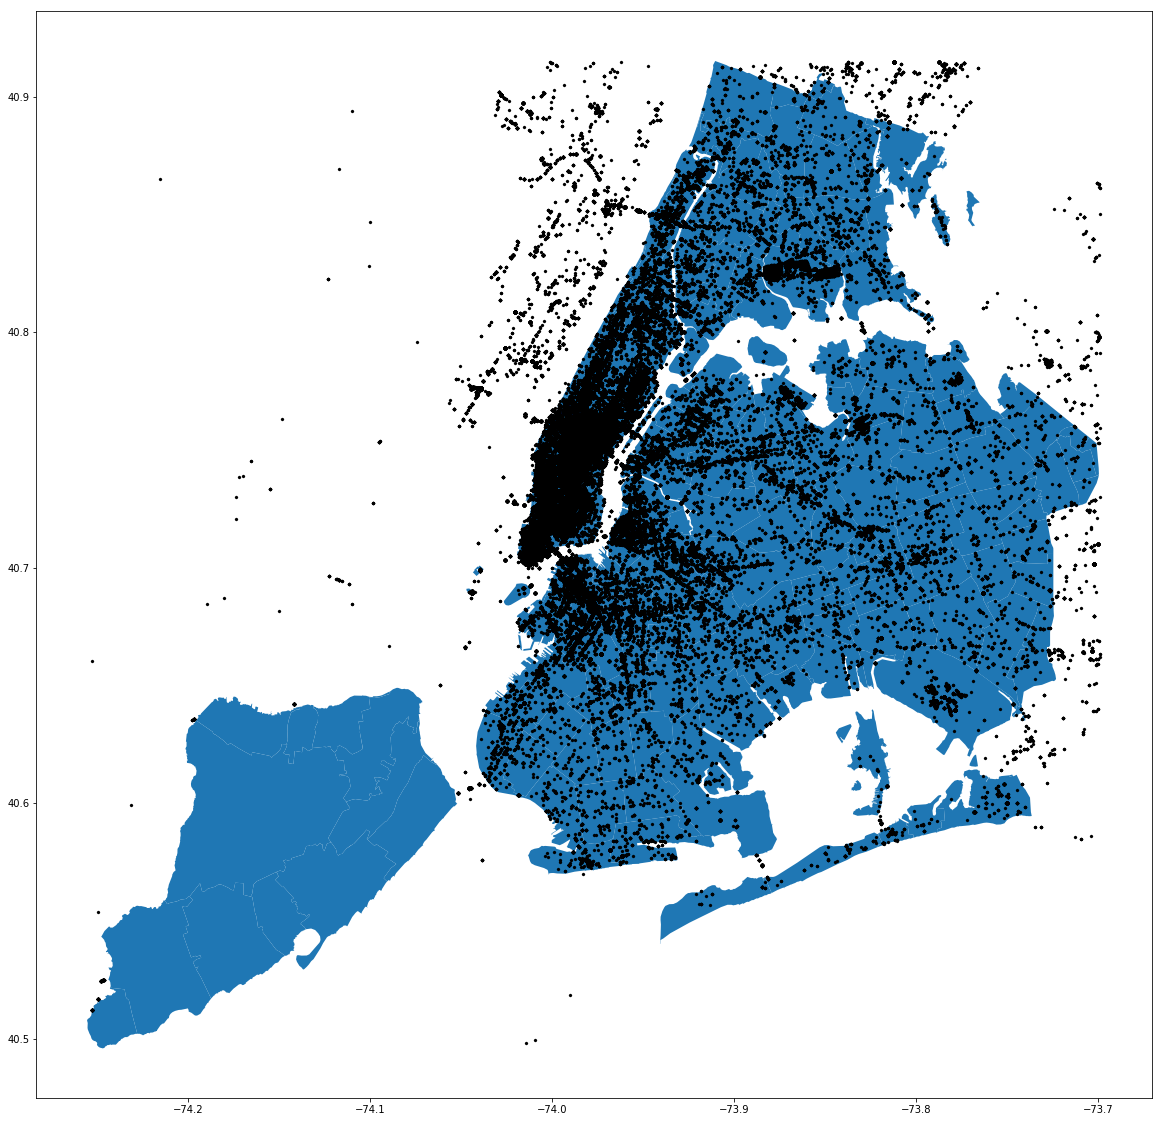

In [14]:
# You will see there're still some out-of-NYC data because the tweets were crawled within a circle range

f = plt.figure(figsize=(20, 20))
ax = f.add_subplot(111)
NYCzip.plot(column=None, ax=ax)
tweets_pd.plot(column=None, color="black", linewidth=0.1, markersize=10, ax=ax)

#### Figure 2: Geo-tweets located within limited range and the map of NYC zipcodes

In [18]:
NYCzip.crs

{}

In [19]:
NYCzip.crs = from_epsg(code=4326)
NYCzip.crs

{'init': 'epsg:4326', 'no_defs': True}

In [20]:
NYCtweets = gpd.tools.sjoin(NYCzip.to_crs(epsg=2263), tweets_pd.to_crs(epsg=2263)).to_crs(epsg=4326)
NYCtweets.head()

zipcode                                           geometry  index_right  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       262729   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       231269   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       202780   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...        11164   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       261331   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                 time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227  2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436  2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845  2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845  2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270  2018-11-25 23:47:25   

              tweet_id  
0  1063696298908495872  
0  1055981634628059136  
0  1062155602531573760  
0  1062158895647522816  
0  1066840813118869504

In [21]:
NYCtweets.shape

(301345, 9)

### 1.5 Time-spatial analysis on NYCtweets

In [19]:
NYCtweets_count = NYCzip.merge(NYCtweets.groupby('zipcode').count()[['content']].reset_index())
NYCtweets_count.head()

zipcode                                           geometry  content
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...      567
1  11004.0  POLYGON Z ((-73.71068374074007 40.750040394509...       21
2  11040.0  POLYGON Z ((-73.70098278625547 40.738895699230...        5
3  11426.0  POLYGON Z ((-73.72270447144122 40.753733714383...      184
4  11365.0  POLYGON Z ((-73.81088634744755 40.727171875759...      349

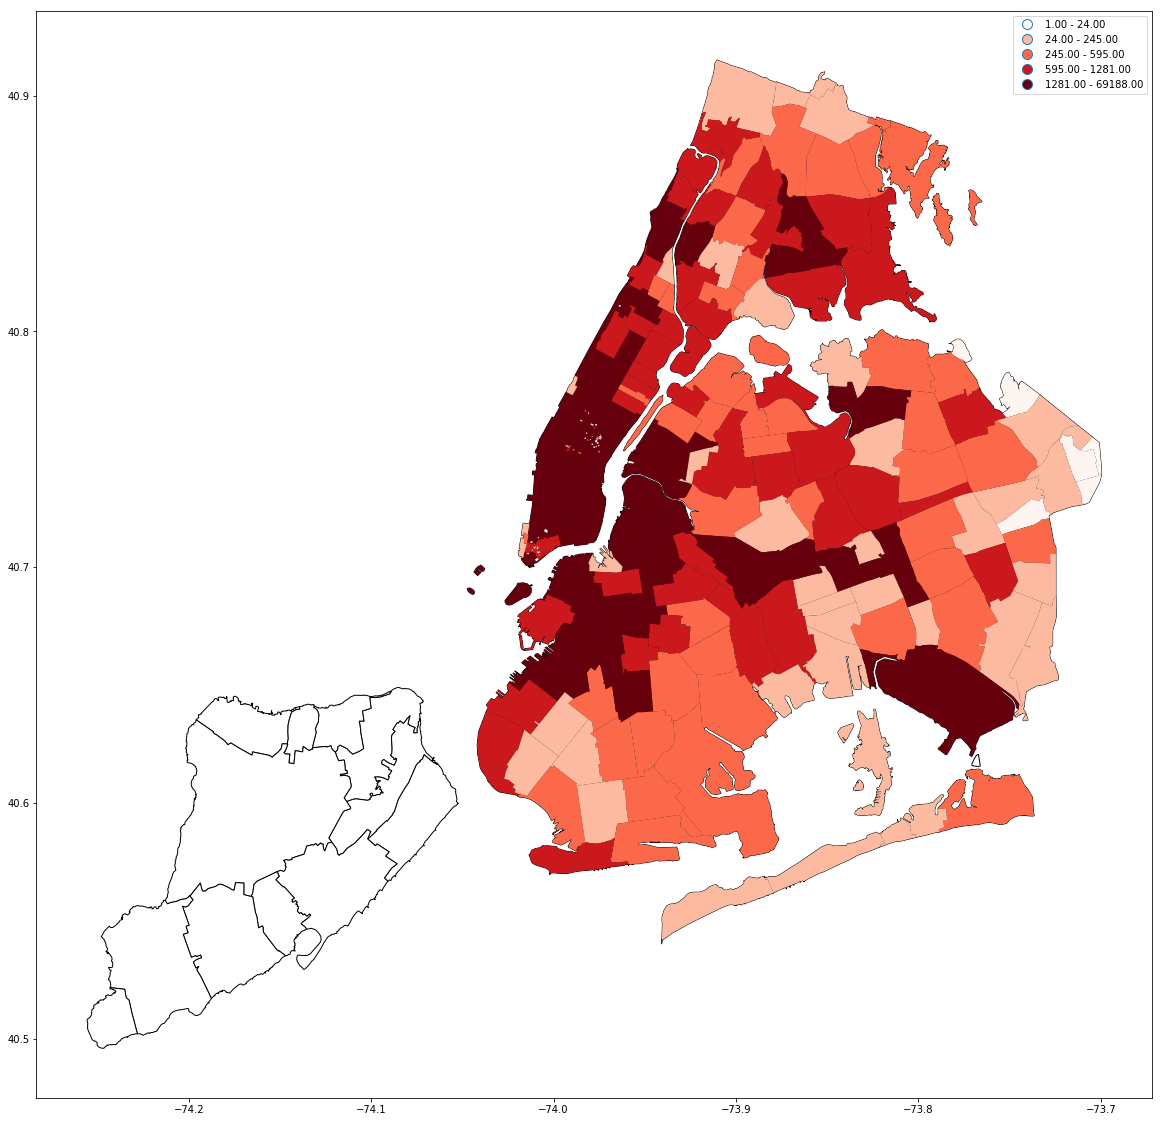

In [20]:
f = plt.figure(figsize=(20, 20))
ax = f.add_subplot(111)
NYCzip.plot(column=None, ax=ax, color="white", edgecolor="black", lw=1)
NYCtweets_count.plot(column='content', ax=ax, cmap='Reds', scheme="quantiles", k=5, legend=True)

#### Figure 3: The total amount of Geo-tweets located within NYC from 2018-10-25 to 2018-11-26. It shows people in NYC are more likely to post geo-tagged tweets in mid & low Manhattan and JFK (Maybe to memory that they are arriving or leaving the city).

In [22]:
NYCtweets['time'] = pd.to_datetime(NYCtweets['time'])
NYCtweets.head()

zipcode                                           geometry  index_right  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       262729   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       231269   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       202780   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...        11164   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       261331   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-25 23:47:25   

              tweet_id  
0  1063696298908495872  
0  1055981634628059136  
0  1062155602531573760  
0  1062158895647522816  
0  1066840813118869504

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


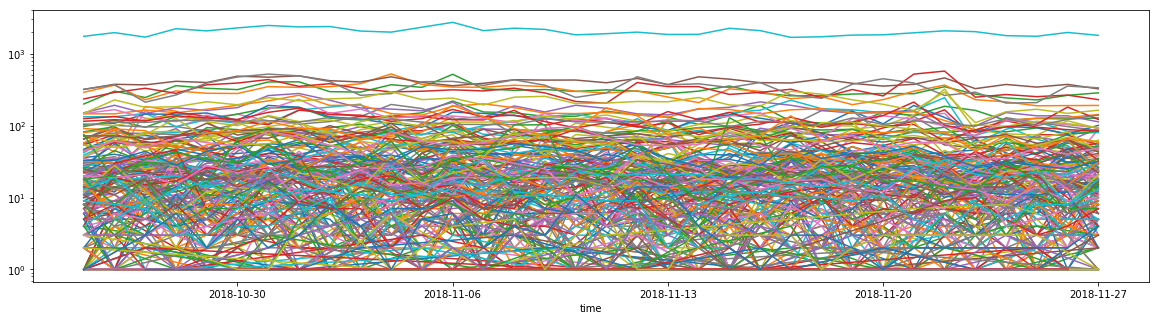

In [22]:
# It will take a while to draw these time series

ZIPCODES = NYCtweets_count.zipcode.values.tolist()

f = plt.figure(figsize=(20, 5))
ax = f.add_subplot(111)
for ZIPCODE in ZIPCODES:
    ChosenNYCtweets = NYCtweets[NYCtweets.zipcode == ZIPCODE]
    ChosenNYCtweets['time'] = ChosenNYCtweets['time'].dt.date
    ChosenNYCtweets.groupby('time').count().reset_index().plot('time', 'content', ax=ax, legend=False, logy=True)

#### Figure 4: Time series of tweeting in every NYC zip from 2018-10-25 to 2018-11-26.

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


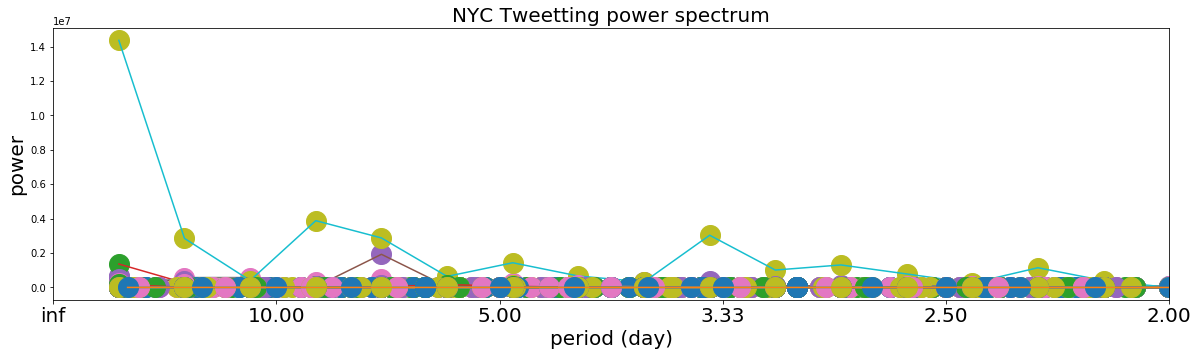

In [23]:
ZIPCODES = NYCtweets_count.zipcode.values.tolist()

f = plt.figure(figsize=(20, 5))
ax = f.add_subplot(111)
for ZIPCODE in ZIPCODES:
    ChosenNYCtweets = NYCtweets[NYCtweets.zipcode == ZIPCODE]
    ChosenNYCtweets['time'] = ChosenNYCtweets['time'].dt.date
    data = ChosenNYCtweets.groupby('time').count().reset_index()['content']
    N = len(data)
    freq = np.abs(np.fft.rfft(data))**2
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (freq[1:]), 'o', ms=20)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (freq[1:]), '-')
    ax.set_xlim(0, 1.0 / 2.0)
    ax.set_xticklabels(["%.2f"%(1 / freq) for freq in ax.get_xticks()], fontsize=20)
    ax.set_ylabel("power", fontsize=20)
    ax.set_xlabel("period (day)", fontsize=20)
    ax.set_title("NYC Tweetting power spectrum", fontsize=20)

#### Figure 5: No obvious periodity.

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


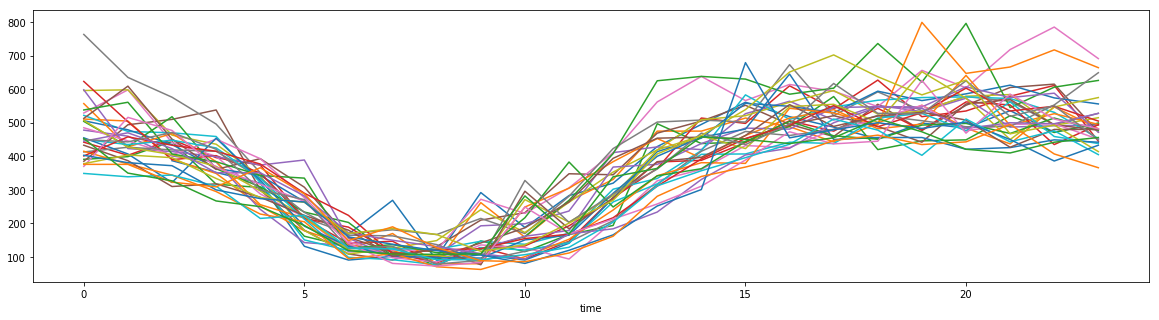

In [24]:
DATETIMES = [dt.datetime.strptime(str(date).split(' ')[0], '%Y-%m-%d').date() for 
             date in pd.date_range('2018-10-25', periods=33).tolist()]

f = plt.figure(figsize=(20, 5))
ax = f.add_subplot(111)
for DATETIME in DATETIMES:
    ChosenNYCtweets = NYCtweets[NYCtweets.time.dt.date == DATETIME]
    ChosenNYCtweets['time'] = ChosenNYCtweets['time'].dt.hour
    ChosenNYCtweets.groupby('time').count().reset_index().plot('time', 'content', ax=ax, legend=False)

#### Figure 6: Time series of NYC tweeting in every day from 2018-10-25 to 2018-11-26. Strangely, we sleep around 5 to 10!

In [23]:
# Select tweets that most likely to post in home

time_ind = (NYCtweets.time.dt.hour < 8) | (NYCtweets.time.dt.hour > 19)
NYCtweets = NYCtweets.loc[time_ind]
print(NYCtweets.shape)
NYCtweets.head()

(155479, 9)


zipcode                                           geometry  index_right  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       262729   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       231269   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       202780   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...        11164   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       261331   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-25 23:47:25   

              tweet_id  
0  1063696298908495872  
0  1055981634628059136  
0  1062155602531573760  
0  1062158895647522816  
0  1066840813118869504

In [26]:
# It will take a long time to generate the dataframe for all time series

ZIPCODES = NYCtweets_count.zipcode.values.tolist()

NYCtweets_TS = pd.DataFrame(NYCtweets[NYCtweets.zipcode == 10001]['time'].\
                            dt.date.unique()).rename(columns={0: 'time'}).set_index('time')
for ZIPCODE in ZIPCODES:
    ChosenNYCtweets = NYCtweets[NYCtweets.zipcode == ZIPCODE]
    ChosenNYCtweets['time'] = ChosenNYCtweets['time'].dt.date
    ChosenNYCtweets_TS = ChosenNYCtweets.groupby('time').count()[['content']].rename(columns={'content': ZIPCODE})
    NYCtweets_TS = pd.concat([NYCtweets_TS, ChosenNYCtweets_TS], axis=1)
NYCtweets_TS.head()

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


11372.0  11004.0  11040.0  11426.0  11365.0  11373.0  11001.0  \
2018-10-25        1      NaN      NaN      3.0      7.0      NaN      NaN   
2018-10-26        1      NaN      NaN      2.0      5.0     12.0      NaN   
2018-10-27       15      NaN      NaN      NaN     30.0     17.0      NaN   
2018-10-28        7      1.0      NaN      1.0      1.0     13.0      NaN   
2018-10-29        3      NaN      NaN      2.0      2.0      8.0      NaN   

            11375.0  11427.0  11374.0   ...     10203.0  10259.0  10260.0  \
2018-10-25        8      NaN      1.0   ...         NaN      NaN      NaN   
2018-10-26       15      NaN      1.0   ...         NaN      NaN      NaN   
2018-10-27        9      1.0      7.0   ...         NaN      NaN      NaN   
2018-10-28       12      NaN      1.0   ...         NaN      NaN      NaN   
2018-10-29        8      NaN      8.0   ...         NaN      NaN      NaN   

            10285.0  10286.0  10065.0  10075.0  10069.0  10281.0  10282.0  
2018-10-25      2.0      NaN       19      3.0      2.0      5.0      NaN  
2018-10-26      2.0      NaN       28      4.0      NaN      3.0      NaN  
2018-10-27      3.0      NaN       25      NaN      NaN      5.0      NaN  
2018-10-28      NaN      NaN       34      4.0      1.0      1.0      2.0  
2018-10-29      NaN      NaN       29      NaN      NaN      1.0      2.0  

[5 rows x 241 columns]

In [27]:
NYCtweets_TS_all = NYCzip.merge(NYCtweets_TS.T.reset_index().rename(columns={'index': 'zipcode'}))
d_rows = NYCtweets_TS_all[NYCtweets_TS_all['zipcode'].duplicated(keep=False)]
NYCtweets_TS_all.drop(d_rows.index, axis=0, inplace=True)
g_items = d_rows.groupby('zipcode').mean()
g_items['zipcode'] = g_items.index
NYCtweets_TS_all = NYCtweets_TS_all.append(g_items)
print(NYCtweets_TS_all.shape)
NYCtweets_TS_all.head()

(228, 36)


/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


zipcode                                           geometry  2018-10-25  \
0.0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...         1.0   
1.0  11004.0  POLYGON Z ((-73.71068374074007 40.750040394509...         NaN   
2.0  11040.0  POLYGON Z ((-73.70098278625547 40.738895699230...         NaN   
3.0  11426.0  POLYGON Z ((-73.72270447144122 40.753733714383...         3.0   
4.0  11365.0  POLYGON Z ((-73.81088634744755 40.727171875759...         7.0   

     2018-10-26  2018-10-27  2018-10-28  2018-10-29  2018-10-30  2018-10-31  \
0.0         1.0        15.0         7.0         3.0         3.0         2.0   
1.0         NaN         NaN         1.0         NaN         NaN         NaN   
2.0         NaN         NaN         NaN         NaN         NaN         NaN   
3.0         2.0         NaN         1.0         2.0         6.0         2.0   
4.0         5.0        30.0         1.0         2.0         6.0         7.0   

     2018-11-01     ...      2018-11-18  2018-11-19  2018-11-20  2018-11-21  \
0.0         5.0     ...             9.0         4.0         8.0         8.0   
1.0         NaN     ...             1.0         1.0         NaN         NaN   
2.0         1.0     ...             NaN         NaN         NaN         NaN   
3.0         1.0     ...             NaN         1.0         NaN         NaN   
4.0         4.0     ...            13.0         5.0         NaN         3.0   

     2018-11-22  2018-11-23  2018-11-24  2018-11-25  2018-11-26  2018-11-27  
0.0        11.0        10.0        27.0         9.0        12.0         4.0  
1.0         NaN         NaN         1.0         NaN         NaN         NaN  
2.0         NaN         NaN         NaN         NaN         NaN         NaN  
3.0         3.0         2.0         2.0         NaN         1.0         1.0  
4.0         8.0         4.0         1.0        14.0         3.0         3.0  

[5 rows x 36 columns]

In [28]:
NYCtweets_TS_all.columns = NYCtweets_TS_all.columns.values.astype(str)

In [29]:
NYCtweets_TS_all.fillna(0, inplace=True)
NYCtweets_TS_all.head()

zipcode                                           geometry  2018-10-25  \
0.0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...         1.0   
1.0  11004.0  POLYGON Z ((-73.71068374074007 40.750040394509...         0.0   
2.0  11040.0  POLYGON Z ((-73.70098278625547 40.738895699230...         0.0   
3.0  11426.0  POLYGON Z ((-73.72270447144122 40.753733714383...         3.0   
4.0  11365.0  POLYGON Z ((-73.81088634744755 40.727171875759...         7.0   

     2018-10-26  2018-10-27  2018-10-28  2018-10-29  2018-10-30  2018-10-31  \
0.0         1.0        15.0         7.0         3.0         3.0         2.0   
1.0         0.0         0.0         1.0         0.0         0.0         0.0   
2.0         0.0         0.0         0.0         0.0         0.0         0.0   
3.0         2.0         0.0         1.0         2.0         6.0         2.0   
4.0         5.0        30.0         1.0         2.0         6.0         7.0   

     2018-11-01     ...      2018-11-18  2018-11-19  2018-11-20  2018-11-21  \
0.0         5.0     ...             9.0         4.0         8.0         8.0   
1.0         0.0     ...             1.0         1.0         0.0         0.0   
2.0         1.0     ...             0.0         0.0         0.0         0.0   
3.0         1.0     ...             0.0         1.0         0.0         0.0   
4.0         4.0     ...            13.0         5.0         0.0         3.0   

     2018-11-22  2018-11-23  2018-11-24  2018-11-25  2018-11-26  2018-11-27  
0.0        11.0        10.0        27.0         9.0        12.0         4.0  
1.0         0.0         0.0         1.0         0.0         0.0         0.0  
2.0         0.0         0.0         0.0         0.0         0.0         0.0  
3.0         3.0         2.0         2.0         0.0         1.0         1.0  
4.0         8.0         4.0         1.0        14.0         3.0         3.0  

[5 rows x 36 columns]

In [ ]:
# This cell is used to generate a group of map plots. If you did not delete the inline output
# the jupyter will tell you it can not save them all in its memory
# So, after run, just paste the code into a new blank cell and delete this cell

list_of_days = NYCtweets_TS_all.columns[2:]
for column in list_of_days:
    f = plt.figure(figsize=(20, 20))
    ax = f.add_subplot(111)
    NYCzip.plot(column=None, ax=ax, color="white", edgecolor="black", lw=1)
    NYCtweets_TS_all.plot(column=column, ax=ax, cmap='Reds', scheme="quantiles", k=5, legend=True)
    plt.annotate(column, (-74.2, 40.9), fontsize=30)
    plt.savefig('Results/TS on %s .png'%column)

In [31]:
datelist = [str(date).split(' ')[0] for date in pd.date_range('2018-10-25', periods=33).tolist()]

filenames = ['Results/TS on %s .png'%date for date in datelist]
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
kargs = {'duration': 1}
imageio.mimsave('Results/TS.gif', images, 'GIF', **kargs)

In [32]:
HTML('<img src="Results/TS.gif">')

#### Figure 7: The time series plotting of Geo-tweets located within NYC from 2018-10-25 to 2018-11-26.

# 2. NLP and Sentiment-quantification

In [33]:
# Why emoji is as important as text?
# In some cases that people use diverse languages, only social media language or "seperate" language
# Emojis can express rich content

HTML('<img src="Data/Case.png">')

### 2.1 Sentiment dictionary

In [3]:
emoji_pd = pd.read_csv('Data/Emoji_Sentiment_Dictionary.csv', skiprows=1)

In [4]:
emoji_pd.head()

Emoji Unicode codepoint  Neg [0…1]  Neut [0…1]  Pos [0…1]  \
0     😂           0x1f602      0.247       0.285      0.468   
1     ❤            0x2764      0.044       0.166      0.790   
2     ♥            0x2665      0.035       0.272      0.693   
3     😍           0x1f60d      0.052       0.219      0.729   
4     😭           0x1f62d      0.436       0.220      0.343   

                          Unicode name  
0               face with tears of joy  
1                    heavy black heart  
2                     black heart suit  
3  smiling face with heart-shaped eyes  
4                   loudly crying face

In [5]:
word_pd = pd.read_table('Data/sentiwordnet.tsv', sep='\t')
word_pd.head()

pos       word_en word_sp  positive  negative  objective  index  synset  \
0   n  neurotropism     NaN     0.125      -0.0      0.875      0  862310   
1   a   ensorcelled     NaN     0.125      -0.0      0.875      0  865765   
2   a     bewitched     NaN     0.125      -0.0      0.875      0  865765   
3   a    mesmerized     NaN     0.125      -0.0      0.875      0  865848   
4   n      training     NaN     0.125      -0.0      0.875      0  893955   

                                             meaning  
0                    an affinity for neural tissues   
1                                     under a spell   
2                                     under a spell   
3  having your attention fixated as though by a s...  
4              activity leading to skilled behavior

### 2.2 Sentence splits

In [24]:
NYCtweets.head()

zipcode                                           geometry  index_right  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       262729   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       231269   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       202780   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...        11164   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       261331   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-25 23:47:25   

              tweet_id  
0  1063696298908495872  
0  1055981634628059136  
0  1062155602531573760  
0  1062158895647522816  
0  1066840813118869504

In [25]:
stopwords = set(json.load(open('Data/stopwords-en.json', 'r')))
stopwords

{'doubtful',
 'shall',
 'bz',
 'inside',
 'consequently',
 'means',
 'looks',
 'mo',
 'webpage',
 'keeps',
 'tr',
 'homepage',
 'states',
 'after',
 'announce',
 'similar',
 'upwards',
 'si',
 'working',
 'kr',
 'hn',
 'later',
 'http',
 'p',
 'gmt',
 'dz',
 'faces',
 'smallest',
 'cmon',
 'having',
 'int',
 'member',
 'changes',
 "didn't",
 'dj',
 'making',
 'qa',
 'going',
 'myse”',
 'null',
 "i'll",
 'vc',
 'bottom',
 'pmid',
 'gp',
 'to',
 'zero',
 'gd',
 'through',
 'appreciate',
 'furthers',
 'line',
 'showns',
 "when'd",
 'ke',
 'my',
 'ky',
 'whats',
 'only',
 'turned',
 'whilst',
 "wouldn't",
 'from',
 'nearly',
 'mu',
 'really',
 'li',
 'sixty',
 'use',
 'according',
 '10',
 "how'll",
 'ml',
 'vg',
 'any',
 'page',
 'order',
 'think',
 'dare',
 'whose',
 'au',
 'thin',
 'bb',
 'ae',
 'undoing',
 'itself',
 'per',
 'mk',
 'ro',
 'md',
 "'twas",
 'wants',
 'found',
 'began',
 'org',
 'maynt',
 'nobody',
 'strongly',
 'known',
 'twice',
 'shows',
 'work',
 'like',
 'let',
 'rece

In [26]:
wnl = WordNetLemmatizer()
table = str.maketrans({key: ' ' for key in string.punctuation})

def Split(em):
    s = ' '.join([wnl.lemmatize(word) for word in [e.strip() for e in em.strip().split(' ') 
                                                   if len(re.findall("http", e)) == 0]])
    em = s.translate(table)
    em_split_emoji = emoji.get_emoji_regexp().split(em)
    em_split_whitespace = [substr.split(' ') for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    em_split = [m.replace("…", "") for m in em_split if (m not in stopwords) and (m.strip() != '')]
    return em_split

NYCtweets['split_content'] = NYCtweets['content'].map(Split)
NYCtweets.head()

zipcode                                           geometry  index_right  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       262729   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       231269   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       202780   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...        11164   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       261331   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-25 23:47:25   

              tweet_id                                      split_content  
0  1063696298908495872  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...  
0  1055981634628059136  [This, wa, delicious, Authentic, shrimp, taco,...  
0  1062155602531573760  [Aquí, estamos, TransPower, UnidadTrans, Todes...  
0  1062158895647522816   [Here, team, ✊🏽, ❤, ️, 😉, 😊, 😘, Club, Evolution]  
0  1066840813118869504              [Just, posted, video, Jackson, Diner]

In [27]:
def extract_emojis(split_list):
    return [c for c in split_list if c in emoji.UNICODE_EMOJI]

NYCtweets['split_emoji'] = NYCtweets['split_content'].map(extract_emojis)
NYCtweets.head()

zipcode                                           geometry  index_right  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       262729   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       231269   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       202780   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...        11164   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       261331   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-25 23:47:25   

              tweet_id                                      split_content  \
0  1063696298908495872  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0  1055981634628059136  [This, wa, delicious, Authentic, shrimp, taco,...   
0  1062155602531573760  [Aquí, estamos, TransPower, UnidadTrans, Todes...   
0  1062158895647522816   [Here, team, ✊🏽, ❤, ️, 😉, 😊, 😘, Club, Evolution]   
0  1066840813118869504              [Just, posted, video, Jackson, Diner]   

        split_emoji  
0                []  
0                []  
0                []  
0  [✊🏽, ❤, 😉, 😊, 😘]  
0                []

In [28]:
def extract_text(split_list, split_emoji):
    return [d for d in split_list if d not in split_emoji]

NYCtweets['split_text'] = NYCtweets.apply(lambda x: extract_text(x['split_content'], x['split_emoji']), axis=1)
NYCtweets.head()

zipcode                                           geometry  index_right  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       262729   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       231269   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       202780   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...        11164   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...       261331   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-25 23:47:25   

              tweet_id                                      split_content  \
0  1063696298908495872  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0  1055981634628059136  [This, wa, delicious, Authentic, shrimp, taco,...   
0  1062155602531573760  [Aquí, estamos, TransPower, UnidadTrans, Todes...   
0  1062158895647522816   [Here, team, ✊🏽, ❤, ️, 😉, 😊, 😘, Club, Evolution]   
0  1066840813118869504              [Just, posted, video, Jackson, Diner]   

        split_emoji                                         split_text  
0                []  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...  
0                []  [This, wa, delicious, Authentic, shrimp, taco,...  
0                []  [Aquí, estamos, TransPower, UnidadTrans, Todes...  
0  [✊🏽, ❤, 😉, 😊, 😘]                   [Here, team, ️, Club, Evolution]  
0                []              [Just, posted, video, Jackson, Diner]

In [29]:
NYCtweets.drop(columns=['index_right'], inplace=True)
NYCtweets.head()

zipcode                                           geometry  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-25 23:47:25   

              tweet_id                                      split_content  \
0  1063696298908495872  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0  1055981634628059136  [This, wa, delicious, Authentic, shrimp, taco,...   
0  1062155602531573760  [Aquí, estamos, TransPower, UnidadTrans, Todes...   
0  1062158895647522816   [Here, team, ✊🏽, ❤, ️, 😉, 😊, 😘, Club, Evolution]   
0  1066840813118869504              [Just, posted, video, Jackson, Diner]   

        split_emoji                                         split_text  
0                []  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...  
0                []  [This, wa, delicious, Authentic, shrimp, taco,...  
0                []  [Aquí, estamos, TransPower, UnidadTrans, Todes...  
0  [✊🏽, ❤, 😉, 😊, 😘]                   [Here, team, ️, Club, Evolution]  
0                []              [Just, posted, video, Jackson, Diner]

### 2.3. Sentiment quantification

In [30]:
emoji_pd.head()

Emoji Unicode codepoint  Neg [0…1]  Neut [0…1]  Pos [0…1]  \
0     😂           0x1f602      0.247       0.285      0.468   
1     ❤            0x2764      0.044       0.166      0.790   
2     ♥            0x2665      0.035       0.272      0.693   
3     😍           0x1f60d      0.052       0.219      0.729   
4     😭           0x1f62d      0.436       0.220      0.343   

                          Unicode name  
0               face with tears of joy  
1                    heavy black heart  
2                     black heart suit  
3  smiling face with heart-shaped eyes  
4                   loudly crying face

In [31]:
emoji_dict = emoji_pd[['Emoji', 'Pos [0…1]', 'Neut [0…1]']].set_index('Emoji').T.to_dict()
emoji_dict

{'¦': {'Neut [0…1]': 0.047, 'Pos [0…1]': 0.767},
 '©': {'Neut [0…1]': 0.621, 'Pos [0…1]': 0.248},
 '®': {'Neut [0…1]': 0.579, 'Pos [0…1]': 0.35},
 '۞': {'Neut [0…1]': 0.778, 'Pos [0…1]': 0.111},
 '۩': {'Neut [0…1]': 0.867, 'Pos [0…1]': 0.067},
 '↪': {'Neut [0…1]': 0.727, 'Pos [0…1]': 0.182},
 '↳': {'Neut [0…1]': 0.778, 'Pos [0…1]': 0.111},
 '↾': {'Neut [0…1]': 0.33299999999999996, 'Pos [0…1]': 0.657},
 '↿': {'Neut [0…1]': 0.33299999999999996, 'Pos [0…1]': 0.657},
 '⇧': {'Neut [0…1]': 0.765, 'Pos [0…1]': 0.17600000000000002},
 '⇨': {'Neut [0…1]': 0.455, 'Pos [0…1]': 0.5},
 '⇩': {'Neut [0…1]': 0.875, 'Pos [0…1]': 0.063},
 '⌒': {'Neut [0…1]': 0.308, 'Pos [0…1]': 0.615},
 '⌚': {'Neut [0…1]': 0.5, 'Pos [0…1]': 0.35},
 '⌛': {'Neut [0…1]': 0.3, 'Pos [0…1]': 0.4},
 '⏩': {'Neut [0…1]': 0.667, 'Pos [0…1]': 0.222},
 '⏰': {'Neut [0…1]': 0.188, 'Pos [0…1]': 0.625},
 '⏳': {'Neut [0…1]': 0.2, 'Pos [0…1]': 0.4},
 'Ⓐ': {'Neut [0…1]': 0.5, 'Pos [0…1]': 0.2},
 'Ⓔ': {'Neut [0…1]': 0.444, 'Pos [0…1]': 0.44

In [32]:
def emoji_score(emoji_list):
    score = 0.0
    count = 0
    if len(emoji_list) == 0:
        return 0.0
    else:
        for chosen_emoji in emoji_list:
            if chosen_emoji in emoji_dict:
                count += 1
                score += emoji_dict[chosen_emoji]['Pos [0…1]']
            else:
                pass
        if count == 0:
            return 0.0
        else:
            return score / count

NYCtweets['emoji_score'] = NYCtweets.split_emoji.map(emoji_score)
NYCtweets.head()

zipcode                                           geometry  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-25 23:47:25   

              tweet_id                                      split_content  \
0  1063696298908495872  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0  1055981634628059136  [This, wa, delicious, Authentic, shrimp, taco,...   
0  1062155602531573760  [Aquí, estamos, TransPower, UnidadTrans, Todes...   
0  1062158895647522816   [Here, team, ✊🏽, ❤, ️, 😉, 😊, 😘, Club, Evolution]   
0  1066840813118869504              [Just, posted, video, Jackson, Diner]   

        split_emoji                                         split_text  \
0                []  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0                []  [This, wa, delicious, Authentic, shrimp, taco,...   
0                []  [Aquí, estamos, TransPower, UnidadTrans, Todes...   
0  [✊🏽, ❤, 😉, 😊, 😘]                   [Here, team, ️, Club, Evolution]   
0                []              [Just, posted, video, Jackson, Diner]   

   emoji_score  
0      0.00000  
0      0.00000  
0      0.00000  
0      0.70275  
0      0.00000

In [33]:
NYCtweets.emoji_score.describe()

count    155479.000000
mean          0.090775
std           0.210116
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.926000
Name: emoji_score, dtype: float64

In [34]:
word_pd.head()

pos       word_en word_sp  positive  negative  objective  index  synset  \
0   n  neurotropism     NaN     0.125      -0.0      0.875      0  862310   
1   a   ensorcelled     NaN     0.125      -0.0      0.875      0  865765   
2   a     bewitched     NaN     0.125      -0.0      0.875      0  865765   
3   a    mesmerized     NaN     0.125      -0.0      0.875      0  865848   
4   n      training     NaN     0.125      -0.0      0.875      0  893955   

                                             meaning  
0                    an affinity for neural tissues   
1                                     under a spell   
2                                     under a spell   
3  having your attention fixated as though by a s...  
4              activity leading to skilled behavior

In [35]:
text_dict = word_pd[['word_en', 'positive', 'objective']].set_index('word_en').T.to_dict()
text_dict

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


{'one_hundred_sixty-five': {'objective': 0.875, 'positive': 0.0},
 'comet-like': {'objective': 0.875, 'positive': 0.0},
 'applicative': {'objective': 0.75, 'positive': 0.25},
 'talk_down': {'objective': 0.875, 'positive': 0.0},
 'apophatism': {'objective': 0.875, 'positive': 0.125},
 'panduriform': {'objective': 0.75, 'positive': 0.25},
 'surreptitious': {'objective': 0.375, 'positive': 0.625},
 'absolute': {'objective': 0.25, 'positive': 0.0},
 'unmercifully': {'objective': 0.75, 'positive': 0.25},
 'panadol': {'objective': 0.5, 'positive': 0.0},
 'ecotourism': {'objective': 0.875, 'positive': 0.125},
 'lhasa': {'objective': 0.875, 'positive': 0.0},
 'shout': {'objective': 0.375, 'positive': 0.0},
 'agreement': {'objective': 0.875, 'positive': 0.125},
 'unethically': {'objective': 0.625, 'positive': 0.0},
 'purgative': {'objective': 0.75, 'positive': 0.25},
 'smokeless': {'objective': 0.875, 'positive': 0.125},
 'wonder_child': {'objective': 0.875, 'positive': 0.125},
 'natural_action

In [36]:
def text_score(text_list):
    score = 0.0
    count = 0
    if len(text_list) == 0:
        return 0.0
    else:
        for chosen_word in text_list:
            if chosen_word in text_dict:
                count += 1
                score += text_dict[chosen_word]['positive']
            else:
                pass
        if count == 0:
            return 0.0
        else:
            return score / count

NYCtweets['text_score'] = NYCtweets.split_text.map(text_score)
NYCtweets.head()

zipcode                                           geometry  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-25 23:47:25   

              tweet_id                                      split_content  \
0  1063696298908495872  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0  1055981634628059136  [This, wa, delicious, Authentic, shrimp, taco,...   
0  1062155602531573760  [Aquí, estamos, TransPower, UnidadTrans, Todes...   
0  1062158895647522816   [Here, team, ✊🏽, ❤, ️, 😉, 😊, 😘, Club, Evolution]   
0  1066840813118869504              [Just, posted, video, Jackson, Diner]   

        split_emoji                                         split_text  \
0                []  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0                []  [This, wa, delicious, Authentic, shrimp, taco,...   
0                []  [Aquí, estamos, TransPower, UnidadTrans, Todes...   
0  [✊🏽, ❤, 😉, 😊, 😘]                   [Here, team, ️, Club, Evolution]   
0                []              [Just, posted, video, Jackson, Diner]   

   emoji_score  text_score  
0      0.00000       0.125  
0      0.00000       0.750  
0      0.00000       0.000  
0      0.70275       0.000  
0      0.00000       0.000

In [37]:
NYCtweets.text_score.describe()

count    155479.000000
mean          0.092809
std           0.174271
min           0.000000
25%           0.000000
50%           0.000000
75%           0.125000
max           1.000000
Name: text_score, dtype: float64

In [38]:
def content_score(content_list):
    score = 0.0
    count = 0
    if len(content_list) == 0:
        return 0.0
    else:
        for chosen in content_list:
            if chosen in text_dict:
                count += 1
                score += text_dict[chosen]['positive']
            elif chosen in emoji_dict:
                count += 1
                score += emoji_dict[chosen]['Pos [0…1]']
            else:
                pass
        if count == 0:
            return 0.0
        else:
            return score / count

NYCtweets['content_score'] = NYCtweets.split_content.map(content_score)
NYCtweets.head()

zipcode                                           geometry  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Aquí estamos :) #TransPower #UnidadTrans #Tode...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Just posted a video @ Jackson Diner https://t....   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:30:04   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-25 23:47:25   

              tweet_id                                      split_content  \
0  1063696298908495872  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0  1055981634628059136  [This, wa, delicious, Authentic, shrimp, taco,...   
0  1062155602531573760  [Aquí, estamos, TransPower, UnidadTrans, Todes...   
0  1062158895647522816   [Here, team, ✊🏽, ❤, ️, 😉, 😊, 😘, Club, Evolution]   
0  1066840813118869504              [Just, posted, video, Jackson, Diner]   

        split_emoji                                         split_text  \
0                []  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0                []  [This, wa, delicious, Authentic, shrimp, taco,...   
0                []  [Aquí, estamos, TransPower, UnidadTrans, Todes...   
0  [✊🏽, ❤, 😉, 😊, 😘]                   [Here, team, ️, Club, Evolution]   
0                []              [Just, posted, video, Jackson, Diner]   

   emoji_score  text_score  content_score  
0      0.00000       0.125        0.12500  
0      0.00000       0.750        0.75000  
0      0.00000       0.000        0.00000  
0      0.70275       0.000        0.70275  
0      0.00000       0.000        0.00000

In [39]:
NYCtweets.content_score.describe()

count    155479.000000
mean          0.145530
std           0.211625
min           0.000000
25%           0.000000
50%           0.000000
75%           0.250000
max           1.000000
Name: content_score, dtype: float64

In [40]:
NYCtweets['score'] = 0.5 * NYCtweets.emoji_score + 0.5 * NYCtweets.text_score
NYCtweets = NYCtweets[NYCtweets.score > 0]
NYCtweets.head()

zipcode                                           geometry  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Hanging with the girls kit.wonder and ninibeen...   
0  She and I are going to have kittens 😺, lol. @ ...   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-26 02:19:19   
0         [-73.88739, 40.7475]  40.747500 -73.887390 2018-11-02 01:04:24   

              tweet_id                                      split_content  \
0  1063696298908495872  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0  1055981634628059136  [This, wa, delicious, Authentic, shrimp, taco,...   
0  1062158895647522816   [Here, team, ✊🏽, ❤, ️, 😉, 😊, 😘, Club, Evolution]   
0  1066879042312269824  [Hanging, girl, kit, ninibeenie510, jacksondin...   
0  1058162877775921152  [She, I, kitten, 😺, lol, Amor, karaoke, Bar, a...   

        split_emoji                                         split_text  \
0                []  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0                []  [This, wa, delicious, Authentic, shrimp, taco,...   
0  [✊🏽, ❤, 😉, 😊, 😘]                   [Here, team, ️, Club, Evolution]   
0                []  [Hanging, girl, kit, ninibeenie510, jacksondin...   
0               [😺]  [She, I, kitten, lol, Amor, karaoke, Bar, amp,...   

   emoji_score  text_score  content_score     score  
0      0.00000      0.1250        0.12500  0.062500  
0      0.00000      0.7500        0.75000  0.375000  
0      0.70275      0.0000        0.70275  0.351375  
0      0.00000      0.0625        0.06250  0.031250  
0      0.60500      0.1250        0.36500  0.365000

In [41]:
NYCtweets.score.describe()

count    70301.000000
mean         0.203008
std          0.149346
min          0.003500
25%          0.062500
50%          0.172750
75%          0.297167
max          0.895000
Name: score, dtype: float64

### 2.4. Time-spatial analysis on NYCtweets's Sentiment

In [42]:
NYCtweets_score = NYCzip.merge(NYCtweets.groupby('zipcode').mean()[['emoji_score', 'text_score', 
                                                                    'content_score', 'score']].reset_index())
NYCtweets_score.head()

zipcode                                           geometry  emoji_score  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...     0.093605   
1  11004.0  POLYGON Z ((-73.71068374074007 40.750040394509...     0.000000   
2  11426.0  POLYGON Z ((-73.72270447144122 40.753733714383...     0.178564   
3  11365.0  POLYGON Z ((-73.81088634744755 40.727171875759...     0.037321   
4  11373.0  POLYGON Z ((-73.88722098467157 40.727526187661...     0.175861   

   text_score  content_score     score  
0    0.207095       0.274109  0.150350  
1    0.225000       0.225000  0.112500  
2    0.141827       0.232456  0.160196  
3    0.188852       0.218081  0.113086  
4    0.141636       0.259544  0.158749

Text(0.5,1,'score')

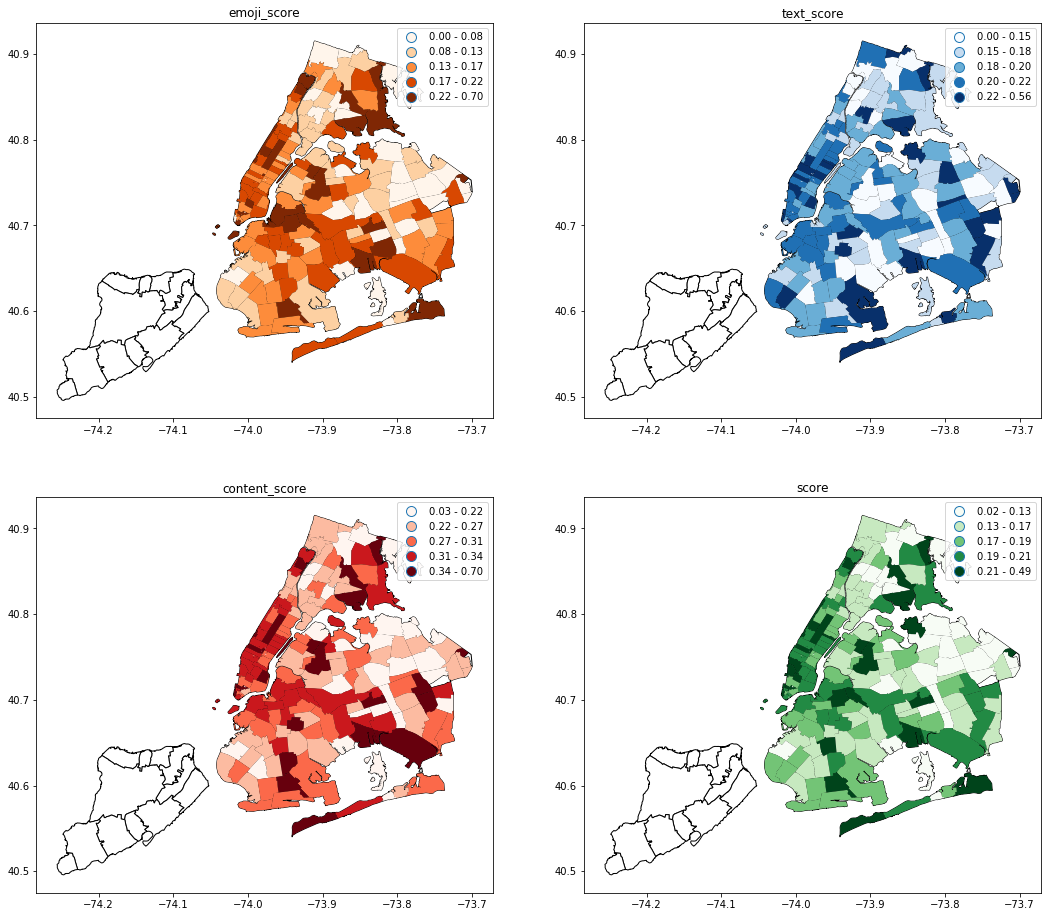

In [56]:
f = plt.figure(figsize=(18, 16))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
NYCzip.plot(column=None, ax=ax1, color="white", edgecolor="black", lw=1)
NYCtweets_score.plot(column='emoji_score', ax=ax1, cmap='Oranges', scheme="quantiles", k=5, legend=True)
ax1.set_title("emoji_score")
NYCzip.plot(column=None, ax=ax2, color="white", edgecolor="black", lw=1)
NYCtweets_score.plot(column='text_score', ax=ax2, cmap='Blues', scheme="quantiles", k=5, legend=True)
ax2.set_title("text_score")
NYCzip.plot(column=None, ax=ax3, color="white", edgecolor="black", lw=1)
NYCtweets_score.plot(column='content_score', ax=ax3, cmap='Reds', scheme="quantiles", k=5, legend=True)
ax3.set_title("content_score")
NYCzip.plot(column=None, ax=ax4, color="white", edgecolor="black", lw=1)
NYCtweets_score.plot(column='score', ax=ax4, cmap='Greens', scheme="quantiles", k=5, legend=True)
ax4.set_title("score")

#### Figure 8: The mean positive emotion scores of geo-tweets located within NYC from 2018-10-25 to 2018-11-26. 

In [57]:
NYCtweets['time'] = pd.to_datetime(NYCtweets['time'])
NYCtweets.head()

zipcode                                           geometry  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   

                                             content  \
0  Midnight Meet &amp; Greet w/ Pastor Boto &amp;...   
0  This was so delicious!  Authentic shrimp #taco...   
0  Here with my #team ✊🏽❤️😉😊😘 @ Club Evolution ht...   
0  Hanging with the girls kit.wonder and ninibeen...   
0  She and I are going to have kittens 😺, lol. @ ...   

                   coordinates        lat        lon                time  \
0    [-73.8922265, 40.7472744]  40.747274 -73.892227 2018-11-17 07:32:14   
0  [-73.88943573, 40.74729162]  40.747292 -73.889436 2018-10-27 00:36:55   
0  [-73.88884474, 40.74733265]  40.747333 -73.888845 2018-11-13 01:43:09   
0        [-73.89127, 40.74749]  40.747490 -73.891270 2018-11-26 02:19:19   
0         [-73.88739, 40.7475]  40.747500 -73.887390 2018-11-02 01:04:24   

              tweet_id                                      split_content  \
0  1063696298908495872  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0  1055981634628059136  [This, wa, delicious, Authentic, shrimp, taco,...   
0  1062158895647522816   [Here, team, ✊🏽, ❤, ️, 😉, 😊, 😘, Club, Evolution]   
0  1066879042312269824  [Hanging, girl, kit, ninibeenie510, jacksondin...   
0  1058162877775921152  [She, I, kitten, 😺, lol, Amor, karaoke, Bar, a...   

        split_emoji                                         split_text  \
0                []  [Midnight, Meet, amp, Greet, Pastor, Boto, amp...   
0                []  [This, wa, delicious, Authentic, shrimp, taco,...   
0  [✊🏽, ❤, 😉, 😊, 😘]                   [Here, team, ️, Club, Evolution]   
0                []  [Hanging, girl, kit, ninibeenie510, jacksondin...   
0               [😺]  [She, I, kitten, lol, Amor, karaoke, Bar, amp,...   

   emoji_score  text_score  content_score     score  
0      0.00000      0.1250        0.12500  0.062500  
0      0.00000      0.7500        0.75000  0.375000  
0      0.70275      0.0000        0.70275  0.351375  
0      0.00000      0.0625        0.06250  0.031250  
0      0.60500      0.1250        0.36500  0.365000

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


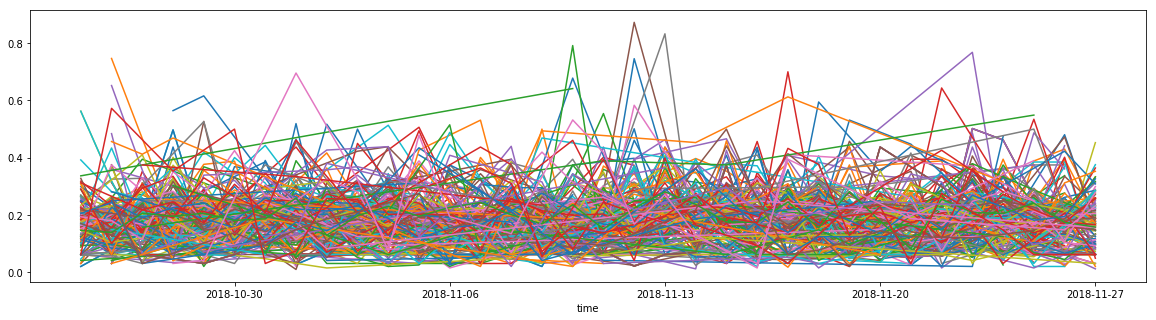

In [58]:
ZIPCODES = NYCtweets_score.zipcode.values.tolist()

f = plt.figure(figsize=(20, 5))
ax = f.add_subplot(111)
for ZIPCODE in ZIPCODES:
    ChosenNYCtweets = NYCtweets[NYCtweets.zipcode == ZIPCODE]
    ChosenNYCtweets['time'] = ChosenNYCtweets['time'].dt.date
    ChosenNYCtweets.groupby('time').mean().reset_index().plot('time', 'score', ax=ax, legend=False)

#### Figure 9: Time series of emotion scores in every NYC zip from 2018-10-25 to 2018-11-26.

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


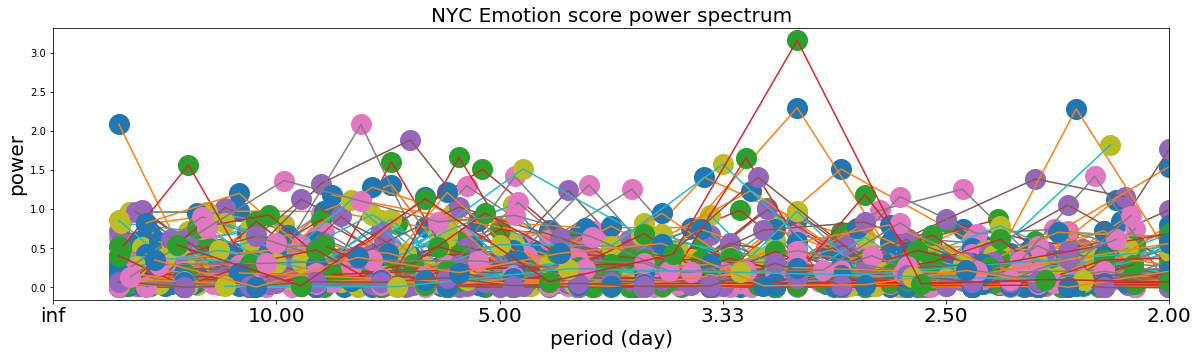

In [59]:
ZIPCODES = NYCtweets_count.zipcode.values.tolist()

f = plt.figure(figsize=(20, 5))
ax = f.add_subplot(111)
for ZIPCODE in ZIPCODES:
    ChosenNYCtweets = NYCtweets[NYCtweets.zipcode == ZIPCODE]
    ChosenNYCtweets['time'] = ChosenNYCtweets['time'].dt.date
    data = ChosenNYCtweets.groupby('time').mean().reset_index()['score']
    N = len(data)
    if N > 0:
        freq = np.abs(np.fft.rfft(data))**2
        ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (freq[1:]), 'o', ms=20)
        ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (freq[1:]), '-')
        ax.set_xlim(0, 1.0 / 2.0)
        ax.set_xticklabels(["%.2f"%(1 / freq) for freq in ax.get_xticks()], fontsize=20)
        ax.set_ylabel("power", fontsize=20)
        ax.set_xlabel("period (day)", fontsize=20)
        ax.set_title("NYC Emotion score power spectrum", fontsize=20)

#### Figure 10: No obvious periodity.

In [60]:
ZIPCODES = NYCtweets_score.zipcode.values.tolist()

NYCtweets_score_TS = pd.DataFrame(NYCtweets[NYCtweets.zipcode == 10001]['time'].\
                                  dt.date.unique()).rename(columns={0: 'time'}).set_index('time')
for ZIPCODE in ZIPCODES:
    ChosenNYCtweets = NYCtweets[NYCtweets.zipcode == ZIPCODE]
    ChosenNYCtweets['time'] = ChosenNYCtweets['time'].dt.date
    ChosenNYCtweets_TS = ChosenNYCtweets.groupby('time').mean()[['score']].rename(columns={'score': ZIPCODE})
    NYCtweets_score_TS = pd.concat([NYCtweets_score_TS, ChosenNYCtweets_TS], axis=1)
NYCtweets_score_TS.head()

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


11372.0  11004.0   11426.0   11365.0   11373.0  11001.0  \
2018-10-25       NaN      NaN       NaN       NaN       NaN      NaN   
2018-10-26       NaN      NaN       NaN       NaN  0.174714      NaN   
2018-10-27  0.176722      NaN       NaN  0.086470  0.172245      NaN   
2018-10-28  0.251500      NaN  0.125000       NaN  0.225458      NaN   
2018-10-29  0.090278      NaN  0.368687  0.083333  0.160562      NaN   

             11375.0  11427.0   11374.0   11366.0    ...     10080.0  10259.0  \
2018-10-25  0.171750      NaN       NaN  0.046875    ...         NaN      NaN   
2018-10-26  0.196500      NaN       NaN  0.154167    ...         NaN      NaN   
2018-10-27  0.235056      NaN  0.041667  0.218750    ...         NaN      NaN   
2018-10-28  0.200250      NaN       NaN  0.208333    ...         NaN      NaN   
2018-10-29  0.052778      NaN  0.119792  0.100000    ...         NaN      NaN   

            10260.0  10285.0  10286.0   10065.0   10075.0  10069.0  10281.0  \
2018-10-25      NaN      NaN      NaN  0.146785  0.062500      NaN      NaN   
2018-10-26      NaN  0.25000      NaN  0.139575  0.572500      NaN  0.26125   
2018-10-27      NaN  0.03125      NaN  0.206774       NaN      NaN  0.03125   
2018-10-28      NaN      NaN      NaN  0.195780  0.353444      NaN      NaN   
2018-10-29      NaN      NaN      NaN  0.206466       NaN      NaN      NaN   

             10282.0  
2018-10-25       NaN  
2018-10-26       NaN  
2018-10-27       NaN  
2018-10-28  0.031250  
2018-10-29  0.041667  

[5 rows x 227 columns]

In [61]:
NYCtweets_score_TS_all = NYCzip.merge(NYCtweets_score_TS.T.reset_index().rename(columns={'index': 'zipcode'}))
d_rows = NYCtweets_score_TS_all[NYCtweets_score_TS_all['zipcode'].duplicated(keep=False)]
NYCtweets_score_TS_all.drop(d_rows.index, axis=0, inplace=True)
g_items = d_rows.groupby('zipcode').mean()
g_items['zipcode'] = g_items.index
NYCtweets_score_TS_all = NYCtweets_score_TS_all.append(g_items)
print(NYCtweets_score_TS_all.shape)
NYCtweets_score_TS_all.head()

(214, 36)


/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


zipcode                                           geometry  2018-10-25  \
0.0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...         NaN   
1.0  11004.0  POLYGON Z ((-73.71068374074007 40.750040394509...         NaN   
2.0  11426.0  POLYGON Z ((-73.72270447144122 40.753733714383...         NaN   
3.0  11365.0  POLYGON Z ((-73.81088634744755 40.727171875759...         NaN   
4.0  11373.0  POLYGON Z ((-73.88722098467157 40.727526187661...         NaN   

     2018-10-26  2018-10-27  2018-10-28  2018-10-29  2018-10-30  2018-10-31  \
0.0         NaN    0.176722    0.251500    0.090278    0.062500         NaN   
1.0         NaN         NaN         NaN         NaN         NaN         NaN   
2.0         NaN         NaN    0.125000    0.368687         NaN    0.292667   
3.0         NaN    0.086470         NaN    0.083333    0.250000         NaN   
4.0    0.174714    0.172245    0.225458    0.160562    0.213759    0.203492   

     2018-11-01     ...      2018-11-18  2018-11-19  2018-11-20  2018-11-21  \
0.0    0.464500     ...        0.250000     0.12500         NaN    0.083333   
1.0         NaN     ...        0.100000         NaN         NaN         NaN   
2.0         NaN     ...             NaN         NaN         NaN         NaN   
3.0    0.437500     ...        0.054167     0.06250         NaN         NaN   
4.0    0.240148     ...        0.162519     0.04875    0.208393    0.216500   

     2018-11-22  2018-11-23  2018-11-24  2018-11-25  2018-11-26  2018-11-27  
0.0    0.281100    0.062500    0.113636    0.058594    0.104953    0.177083  
1.0         NaN         NaN    0.125000         NaN         NaN         NaN  
2.0    0.062500    0.208333    0.026042         NaN         NaN         NaN  
3.0    0.265100         NaN    0.125000    0.034722         NaN         NaN  
4.0    0.277375    0.315992    0.131485    0.160250    0.107611    0.062500  

[5 rows x 36 columns]

In [62]:
NYCtweets_score_TS_all.columns = NYCtweets_score_TS_all.columns.values.astype(str)

In [63]:
NYCtweets_score_TS_all.fillna(0, inplace=True)
NYCtweets_score_TS_all.head()

zipcode                                           geometry  2018-10-25  \
0.0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...         0.0   
1.0  11004.0  POLYGON Z ((-73.71068374074007 40.750040394509...         0.0   
2.0  11426.0  POLYGON Z ((-73.72270447144122 40.753733714383...         0.0   
3.0  11365.0  POLYGON Z ((-73.81088634744755 40.727171875759...         0.0   
4.0  11373.0  POLYGON Z ((-73.88722098467157 40.727526187661...         0.0   

     2018-10-26  2018-10-27  2018-10-28  2018-10-29  2018-10-30  2018-10-31  \
0.0    0.000000    0.176722    0.251500    0.090278    0.062500    0.000000   
1.0    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
2.0    0.000000    0.000000    0.125000    0.368687    0.000000    0.292667   
3.0    0.000000    0.086470    0.000000    0.083333    0.250000    0.000000   
4.0    0.174714    0.172245    0.225458    0.160562    0.213759    0.203492   

     2018-11-01     ...      2018-11-18  2018-11-19  2018-11-20  2018-11-21  \
0.0    0.464500     ...        0.250000     0.12500    0.000000    0.083333   
1.0    0.000000     ...        0.100000     0.00000    0.000000    0.000000   
2.0    0.000000     ...        0.000000     0.00000    0.000000    0.000000   
3.0    0.437500     ...        0.054167     0.06250    0.000000    0.000000   
4.0    0.240148     ...        0.162519     0.04875    0.208393    0.216500   

     2018-11-22  2018-11-23  2018-11-24  2018-11-25  2018-11-26  2018-11-27  
0.0    0.281100    0.062500    0.113636    0.058594    0.104953    0.177083  
1.0    0.000000    0.000000    0.125000    0.000000    0.000000    0.000000  
2.0    0.062500    0.208333    0.026042    0.000000    0.000000    0.000000  
3.0    0.265100    0.000000    0.125000    0.034722    0.000000    0.000000  
4.0    0.277375    0.315992    0.131485    0.160250    0.107611    0.062500  

[5 rows x 36 columns]

In [ ]:
# This cell is used to generate a group of map plots. If you did not delete the inline output
# the jupyter will tell you it can not save them all in its memory
# So, after run, just paste the code into a new blank cell and delete this cell

list_of_days = NYCtweets_score_TS_all.columns[2:]
for column in list_of_days:
    f = plt.figure(figsize=(20, 20))
    ax = f.add_subplot(111)
    NYCzip.plot(column=None, ax=ax, color="white", edgecolor="black", lw=1)
    NYCtweets_score_TS_all.plot(column=column, ax=ax, cmap='Greens', scheme="quantiles", k=5, legend=True)
    plt.annotate(column, (-74.2, 40.9), fontsize=30)
    plt.savefig('Results/Score_TS on %s .png'%column)

In [65]:
datelist = [str(date).split(' ')[0] for date in pd.date_range('2018-10-25', periods=33).tolist()]

filenames = ['Results/Score_TS on %s .png'%date for date in datelist]
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
kargs = {'duration': 1}
imageio.mimsave('Results/Score_TS.gif', images, 'GIF', **kargs)

In [66]:
HTML('<img src="Results/Score_TS.gif">')

#### Figure 11: The time series plotting of the mean positive emotion scores of Geo-tweets located within NYC from 2018-10-25 to 2018-11-26

# 3. Feature Loading

### 3.1 Income
- Download raw data here: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_17_5YR_B19013&prodType=table

In [67]:
income_pd = pd.read_csv('Data/NYCIncome.csv')[['zipcode', 'mean household income']]
income_pd.head()

zipcode  mean household income
0    10001               162724.0
1    10002                64196.0
2    10003               171737.0
3    10004               173800.0
4    10005               193229.0

In [68]:
income_pd.shape

(1711, 2)

In [69]:
income_pd.describe()

zipcode  mean household income
count   1711.000000            1711.000000
mean   12757.231444           83161.733489
std     1307.590974           40600.780104
min    10001.000000           16981.000000
25%    11788.500000           59237.000000
50%    12837.000000           70639.000000
75%    13779.000000           93640.500000
max    14905.000000          392959.000000

In [70]:
NYCincome = NYCzip.merge(income_pd)
NYCincome.head()

zipcode                                           geometry  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...   
1  11004.0  POLYGON Z ((-73.71068374074007 40.750040394509...   
2  11040.0  POLYGON Z ((-73.70098278625547 40.738895699230...   
3  11426.0  POLYGON Z ((-73.72270447144122 40.753733714383...   
4  11365.0  POLYGON Z ((-73.81088634744755 40.727171875759...   

   mean household income  
0                66921.0  
1               101875.0  
2               133079.0  
3                91834.0  
4                81340.0

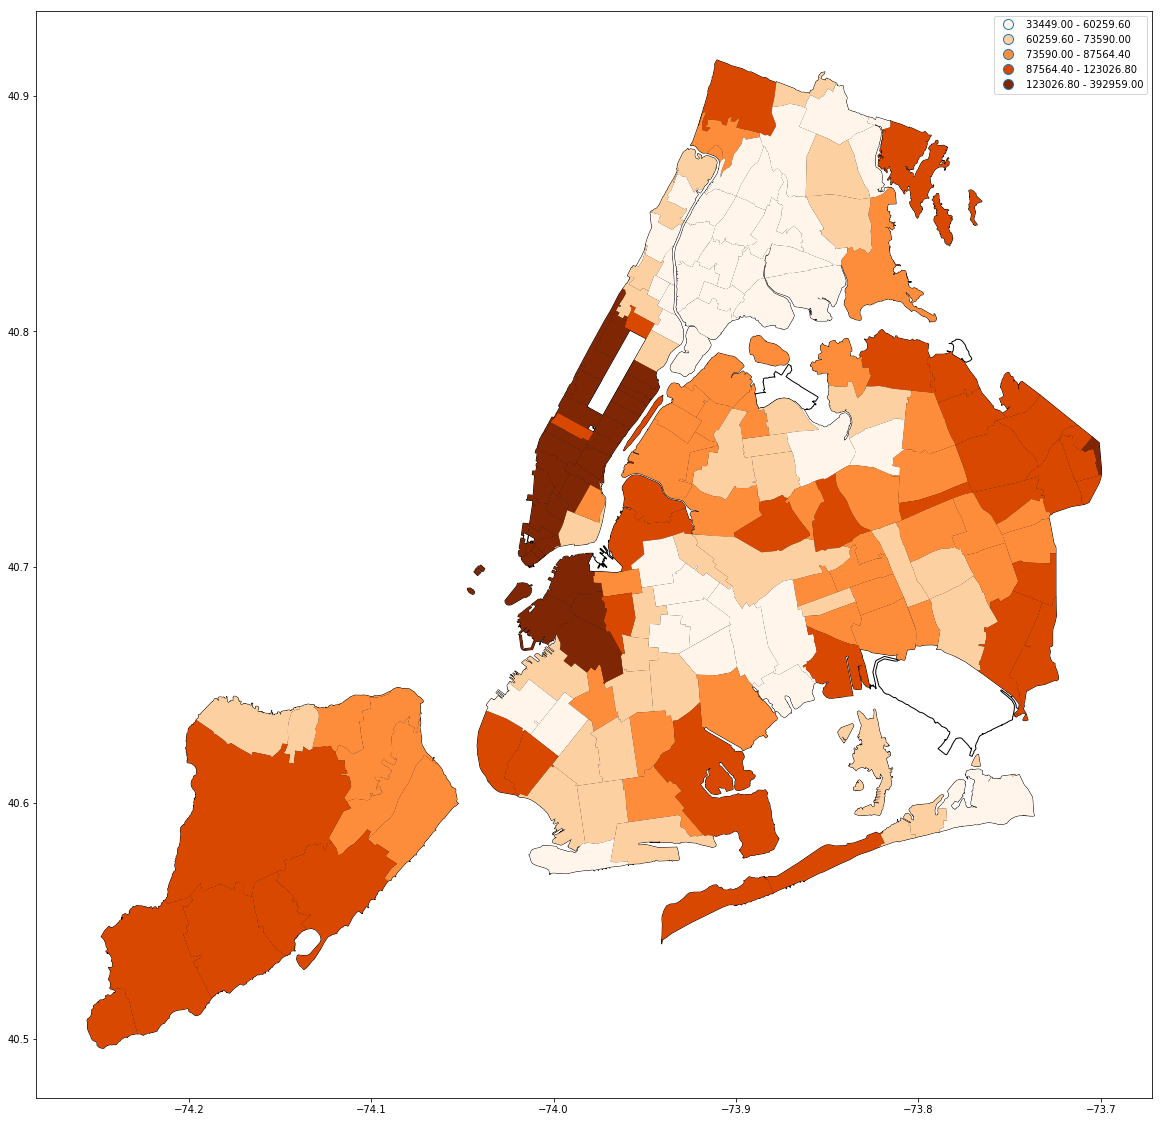

In [71]:
f = plt.figure(figsize=(20, 20))
ax = f.add_subplot(111)
NYCzip.plot(column=None, ax=ax, color="white", edgecolor="black", lw=1)
NYCincome.plot(column='mean household income', ax=ax, cmap='Oranges', scheme="quantiles", k=5, legend=True)

#### Figure 12: The mean household income of NYC zips. 

### 3.2 landuse
- Download raw PLUTO data here: https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

In [72]:
landuse_pd = pd.read_csv('Data/NYClanduse.csv').iloc[:, 1:]
landuse_pd.head()

Borough  ZipCode             Address                           LandUse  \
0      MN    10004  1 GOVERNORS ISLAND  Public Facilities & Institutions   
1      MN    10004    1 LIBERTY ISLAND  Public Facilities & Institutions   
2      MN    10004      4 SOUTH STREET          Transportation & Utility   
3      MN    10004     10 SOUTH STREET          Transportation & Utility   
4      MN    10004            1 PIER 6          Transportation & Utility   

     XCoord    YCoord  NumBldgs  AssessLand  AssessProperty  \
0  979071.0  190225.0       159   104445450        61596900   
1  971677.0  190636.0        11     4225950         9348750   
2  980670.0  194440.0         2    18818100        15336450   
3  981037.0  194506.0         1    18787500         6602400   
4  981687.0  194732.0         1    15255450         2922750   

               Location               geometry  
0  (979071.0, 190225.0)  POINT (979071 190225)  
1  (971677.0, 190636.0)  POINT (971677 190636)  
2  (980670.0, 194440.0)  POINT (980670 194440)  
3  (981037.0, 194506.0)  POINT (981037 194506)  
4  (981687.0, 194732.0)  POINT (981687 194732)

In [73]:
# remove outliers by Num of bildings
sum(landuse_pd.NumBldgs <= 2) / len(landuse_pd)

0.9873813666086748

In [74]:
landuse_pd = landuse_pd[landuse_pd.NumBldgs <= 2]
landuse_pd.head()

Borough  ZipCode          Address                        LandUse    XCoord  \
2      MN    10004   4 SOUTH STREET       Transportation & Utility  980670.0   
3      MN    10004  10 SOUTH STREET       Transportation & Utility  981037.0   
4      MN    10004         1 PIER 6       Transportation & Utility  981687.0   
7      MN    10004   1 SOUTH STREET  Commercial & Office Buildings  980245.0   
8      MN    10004   1 WATER STREET  Commercial & Office Buildings  980917.0   

     YCoord  NumBldgs  AssessLand  AssessProperty              Location  \
2  194440.0         2    18818100        15336450  (980670.0, 194440.0)   
3  194506.0         1    18787500         6602400  (981037.0, 194506.0)   
4  194732.0         1    15255450         2922750  (981687.0, 194732.0)   
7  194640.0         2    11070000         3470850  (980245.0, 194640.0)   
8  195090.0         1    47407500       177580802  (980917.0, 195090.0)   

                geometry  
2  POINT (980670 194440)  
3  POINT (981037 194506)  
4  POINT (981687 194732)  
7  POINT (980245 194640)  
8  POINT (980917 195090)

In [75]:
landuse_pd.shape

(822933, 11)

In [76]:
# It takes about 5 mins to covert the coordinates

def convert(x, y):
    state_plane = pyproj.Proj(init='EPSG:2263', preserve_units=True)
    wgs = pyproj.Proj(proj='latlong', datum='WGS84', ellps='WGS84')
    lng, lat = pyproj.transform(state_plane, wgs, x, y)
    return lng, lat

landuse_pd['lonlat'] = landuse_pd.apply(lambda x: convert(x.XCoord, x.YCoord), axis=1)
landuse_pd.head()

Borough  ZipCode          Address                        LandUse    XCoord  \
2      MN    10004   4 SOUTH STREET       Transportation & Utility  980670.0   
3      MN    10004  10 SOUTH STREET       Transportation & Utility  981037.0   
4      MN    10004         1 PIER 6       Transportation & Utility  981687.0   
7      MN    10004   1 SOUTH STREET  Commercial & Office Buildings  980245.0   
8      MN    10004   1 WATER STREET  Commercial & Office Buildings  980917.0   

     YCoord  NumBldgs  AssessLand  AssessProperty              Location  \
2  194440.0         2    18818100        15336450  (980670.0, 194440.0)   
3  194506.0         1    18787500         6602400  (981037.0, 194506.0)   
4  194732.0         1    15255450         2922750  (981687.0, 194732.0)   
7  194640.0         2    11070000         3470850  (980245.0, 194640.0)   
8  195090.0         1    47407500       177580802  (980917.0, 195090.0)   

                geometry                                   lonlat  
2  POINT (980670 194440)  (-74.01291116969608, 40.70036888897244)  
3  POINT (981037 194506)   (-74.0115876259819, 40.70055018440018)  
4  POINT (981687 194732)  (-74.00924349884778, 40.70117071365149)  
7  POINT (980245 194640)  (-74.0144440391975, 40.700917660042165)  
8  POINT (980917 195090)  (-74.01202069281624, 40.70215308325749)

In [77]:
landuse_pd['geometry'] = landuse_pd[['lonlat']].applymap(lambda x:Point(x))

In [78]:
landuse_pd.drop(columns=['XCoord', 'YCoord', 'Location', 'lonlat'], inplace=True)
landuse_pd.head()

Borough  ZipCode          Address                        LandUse  NumBldgs  \
2      MN    10004   4 SOUTH STREET       Transportation & Utility         2   
3      MN    10004  10 SOUTH STREET       Transportation & Utility         1   
4      MN    10004         1 PIER 6       Transportation & Utility         1   
7      MN    10004   1 SOUTH STREET  Commercial & Office Buildings         2   
8      MN    10004   1 WATER STREET  Commercial & Office Buildings         1   

   AssessLand  AssessProperty                                      geometry  
2    18818100        15336450  POINT (-74.01291116969608 40.70036888897244)  
3    18787500         6602400   POINT (-74.0115876259819 40.70055018440018)  
4    15255450         2922750  POINT (-74.00924349884778 40.70117071365149)  
7    11070000         3470850   POINT (-74.0144440391975 40.70091766004217)  
8    47407500       177580802  POINT (-74.01202069281624 40.70215308325749)

In [79]:
landuse_pd = gpd.GeoDataFrame(landuse_pd)
landuse_pd.crs = from_epsg(code=4326)
landuse_pd.crs

{'init': 'epsg:4326', 'no_defs': True}

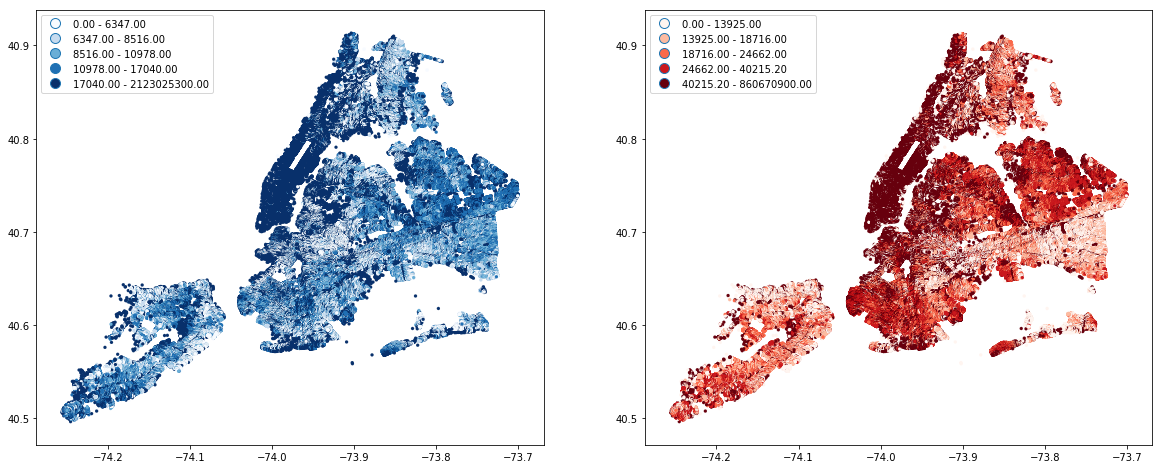

In [80]:
f = plt.figure(figsize=(20, 8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
landuse_pd.plot(column='AssessLand', ax=ax1, cmap='Blues', alpha=1, linewidth=0.1, markersize=10, 
                scheme="quantiles", k=5, legend=True)
landuse_pd.plot(column='AssessProperty', ax=ax2, cmap='Reds', alpha=1, linewidth=0.1, markersize=10, 
                scheme="quantiles", k=5, legend=True)

#### Figure 13: The assessment of land and its property within NYC.

In [81]:
landuse_pd.LandUse.unique()

array(['Transportation & Utility', 'Commercial & Office Buildings',
       'Open Space & Outdoor Recreation',
       'Mixed Residential & Commercial Buildings',
       'Public Facilities & Institutions',
       'Multi-Family Elevator Buildings', 'Parking Facilities',
       'Multi-Family Walk-Up Buildings', 'Vacant Land',
       'Industrial & Manufacturing', 'One &Two Family Buildings'], dtype=object)

In [82]:
filter_landuse = ['Mixed Residential & Commercial Buildings', 'Multi-Family Elevator Buildings', 
                  'Multi-Family Walk-Up Buildings', 'One &Two Family Buildings']

In [83]:
WL_pd = landuse_pd[landuse_pd.LandUse.isin(filter_landuse)]
WL_pd.head()

Borough  ZipCode           Address  \
13      MN    10004   28 WATER STREET   
16      MN    10004  105 BROAD STREET   
20      MN    10004   60 PEARL STREET   
21      MN    10004   1 COENTIES SLIP   
22      MN    10004   32 WATER STREET   

                                     LandUse  NumBldgs  AssessLand  \
13  Mixed Residential & Commercial Buildings         1      247500   
16  Mixed Residential & Commercial Buildings         1      540000   
20  Mixed Residential & Commercial Buildings         1       72346   
21  Mixed Residential & Commercial Buildings         1     1741500   
22  Mixed Residential & Commercial Buildings         1      399465   

    AssessProperty                                      geometry  
13          142200  POINT (-74.01107956228412 40.70325931815101)  
16          429750  POINT (-74.01135365107673 40.70317145895466)  
20          551781   POINT (-74.01108680566813 40.7034404719544)  
21         4680900  POINT (-74.01078023920937 40.70342677724911)  
22         1350134  POINT (-74.01095695677127 40.70338009955513)

In [84]:
NYCLand = NYCzip.set_index('zipcode').merge(WL_pd.groupby('ZipCode').mean(), left_index=True, right_index=True)
NYCLand.head()

geometry  NumBldgs  \
10001.0  POLYGON Z ((-74.00827017711134 40.752587143684...  1.079576   
10002.0  POLYGON Z ((-73.97441674489379 40.736424418654...  1.069324   
10003.0  POLYGON Z ((-73.97986374196766 40.734974465738...  1.049054   
10004.0  POLYGON Z ((-74.00596661578348 40.704324322529...  1.073171   
10004.0  POLYGON Z ((-74.04166368343016 40.696449871832...  1.073171   

           AssessLand  AssessProperty  
10001.0  1.011239e+06    6.243573e+06  
10002.0  2.920350e+05    1.473522e+06  
10003.0  4.169369e+05    2.292589e+06  
10004.0  2.617933e+06    1.447504e+07  
10004.0  2.617933e+06    1.447504e+07

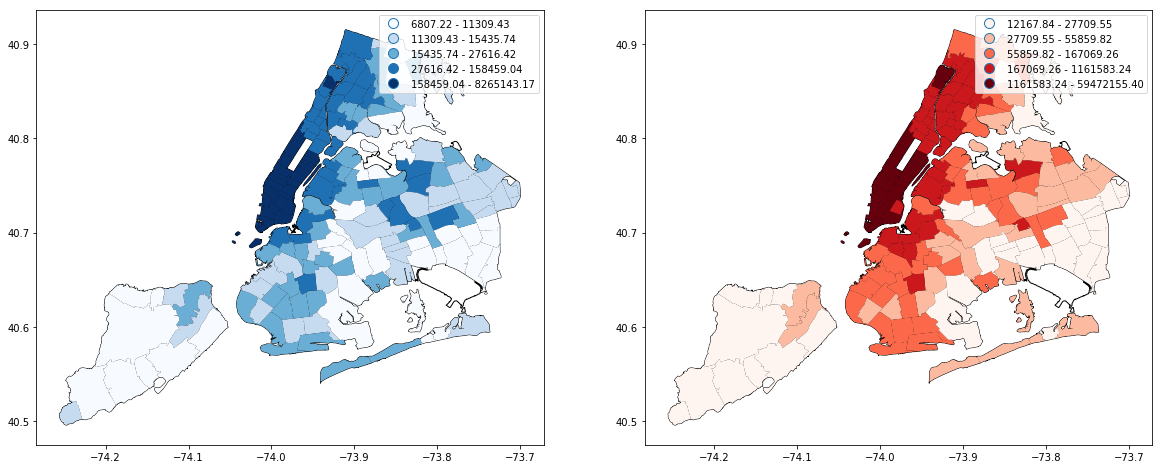

In [85]:
f = plt.figure(figsize=(20, 8))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
NYCzip.plot(column=None, ax=ax1, color="white", edgecolor="black", lw=1)
NYCLand.plot(column='AssessLand', ax=ax1, cmap='Blues', scheme="quantiles", k=5, legend=True)
NYCzip.plot(column=None, ax=ax2, color="white", edgecolor="black", lw=1)
NYCLand.plot(column='AssessProperty', ax=ax2, cmap='Reds', scheme="quantiles", k=5, legend=True)

#### Figure 14: The mean of the assessment of land and its property in NYC zips.

#### 3.2.1 'Sjoin' on landuse and tweets

In [86]:
# Thiw will take a very very long time to sjoin the every buildings and its nearest tweets
# I only choose some of the data as an example here
# we will not use the result below

area = Polygon(WL_pd.iloc[:10, :].geometry.unary_union)
sample = tweets_pd.iloc[:10, :]
lands = []
for i, row in sample.iterrows():
    land_xy = [o.wkt for o in nearest_points(row.geometry, area)][1]
    lands.append(WL_pd[WL_pd.geometry.astype(str) == land_xy]['AssessLand'].values[0])
sample['AssessLand'] = lands
sample

/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


content  \
0   Work so hard that one day your signature will ...   
1   #inspiration and LOTS of nuggets and pieces of...   
2   Cleared: Closure on #RiderAvenueAndEast138ThSt...   
3   Voting and puddle jumping 🗳 ☔️ so much fun 🥳 #...   
4   LOKILLO ENTERTAINMENT ITS AT\nRAICES  KITCHEN ...   
5   Can you recommend anyone for this #job in #New...   
6   Up in the air again, but can’t wait to touch d...   
7            A Day by Design  https://t.co/dvmV0L5ne9   
9   4th Quarter.  Look Who’s Not Watching. #burnto...   
10  A NEW BOMB-ASS CLAY MASK?! Read about the no B...   

                    coordinates        lat        lon                 time  \
0         [-73.98333, 40.76644]  40.766440 -73.983330  2018-11-15 18:39:22   
1   [-74.00777778, 40.74555556]  40.745556 -74.007778  2018-11-15 17:25:09   
2       [-73.928097, 40.811791]  40.811791 -73.928097  2018-11-04 21:58:18   
3   [-73.76897134, 40.75769926]  40.757699 -73.768971  2018-11-06 18:19:14   
4         [-73.92016, 40.86634]  40.866340 -73.920160  2018-11-20 18:38:58   
5     [-73.8648268, 40.8447819]  40.844782 -73.864827  2018-11-01 21:21:52   
6       [-73.778889, 40.639722]  40.639722 -73.778889  2018-11-08 14:50:05   
7     [-74.0007613, 40.7207559]  40.720756 -74.000761  2018-11-07 17:22:48   
9           [-74.0036, 40.7358]  40.735800 -74.003600  2018-11-18 03:51:49   
10          [-74.0064, 40.7142]  40.714200 -74.006400  2018-11-20 11:01:56   

               tweet_id                                geometry  AssessLand  
0   1063139412631003146              POINT (-73.98333 40.76644)       82261  
1   1063120733776289792        POINT (-74.00777778 40.74555556)       82261  
2   1059203206008446976    POINT (-73.92809699999999 40.811791)       82261  
3   1059872855515631616  POINT (-73.76897133999999 40.75769926)     1741500  
4   1064951251371143169              POINT (-73.92016 40.86634)       82261  
5   1058106876741615616          POINT (-73.8648268 40.8447819)     1741500  
6   1060544996221296647    POINT (-73.77888900000001 40.639722)     1741500  
7   1060221037831434241   POINT (-74.00076129999999 40.7207559)       82261  
9   1064003214524198914      POINT (-74.00360000000001 40.7358)       82261  
10  1064836233791066112                POINT (-74.0064 40.7142)       82261

### 3.3 Feature generation

In [141]:
NYCfeature = NYCLand.reset_index().rename(columns={'index': 'zipcode'}).merge(NYCincome.drop(columns=['geometry']))
d_rows = NYCfeature[NYCfeature['zipcode'].duplicated(keep=False)]
NYCfeature.drop(d_rows.index, axis=0, inplace=True)
g_items = d_rows.groupby('zipcode').mean()
g_items['zipcode'] = g_items.index
NYCfeature = NYCfeature.append(g_items).reset_index().drop(columns=['index'], axis=1)
print(NYCfeature.shape)
NYCfeature.head()

(179, 6)


/nfshome/lj1230/.conda/envs/myEnv/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


AssessLand  AssessProperty  NumBldgs  \
0  1.011239e+06    6.243573e+06  1.079576   
1  2.920350e+05    1.473522e+06  1.069324   
2  4.169369e+05    2.292589e+06  1.049054   
3  8.265143e+06    3.399478e+07  1.083333   
4  2.117214e+06    1.285995e+07  1.000000   

                                            geometry  mean household income  \
0  POLYGON Z ((-74.00827017711134 40.752587143684...               162724.0   
1  POLYGON Z ((-73.97441674489379 40.736424418654...                64196.0   
2  POLYGON Z ((-73.97986374196766 40.734974465738...               171737.0   
3  POLYGON Z ((-74.00596661578348 40.704324322529...               193229.0   
4  POLYGON Z ((-74.01123100044997 40.710366883753...               174312.0   

   zipcode  
0  10001.0  
1  10002.0  
2  10003.0  
3  10005.0  
4  10006.0

# 4. Correlation Analysis

### 4.1 Try 3 features

In [142]:
NYCData = NYCfeature.merge(NYCtweets.groupby('zipcode').mean()[['emoji_score', 'text_score', 
                                                                'content_score', 'score']].reset_index())
NYCData = NYCData.rename(columns={'mean household income': 'mean_income'})
NYCData = NYCData[['AssessLand', 'AssessProperty', 'mean_income', 
                   'content_score', 'text_score', 'emoji_score', 'score']]
NYCData.head()

AssessLand  AssessProperty  mean_income  content_score  text_score  \
0  1.011239e+06    6.243573e+06     162724.0       0.321180    0.202377   
1  2.920350e+05    1.473522e+06      64196.0       0.302879    0.189755   
2  4.169369e+05    2.292589e+06     171737.0       0.321930    0.218046   
3  8.265143e+06    3.399478e+07     193229.0       0.312889    0.224669   
4  2.117214e+06    1.285995e+07     174312.0       0.277121    0.185994   

   emoji_score     score  
0     0.187339  0.194858  
1     0.198565  0.194160  
2     0.177017  0.197532  
3     0.166850  0.195759  
4     0.146513  0.166254

In [143]:
NYCData.iloc[:, :3] = scale(NYCData.iloc[:, :3], axis=0)
NYCData.head()

AssessLand  AssessProperty  mean_income  content_score  text_score  \
0    0.635338        0.531722     1.222160       0.321180    0.202377   
1   -0.053623       -0.102250    -0.564562       0.302879    0.189755   
2    0.066027        0.006609     1.385603       0.321930    0.218046   
3    7.584219        4.220044     1.775342       0.312889    0.224669   
4    1.694808        1.411083     1.432299       0.277121    0.185994   

   emoji_score     score  
0     0.187339  0.194858  
1     0.198565  0.194160  
2     0.177017  0.197532  
3     0.166850  0.195759  
4     0.146513  0.166254

In [144]:
NYCData.corr()

AssessLand  AssessProperty  mean_income  content_score  \
AssessLand        1.000000        0.893704     0.569888       0.355519   
AssessProperty    0.893704        1.000000     0.559398       0.386493   
mean_income       0.569888        0.559398     1.000000       0.373503   
content_score     0.355519        0.386493     0.373503       1.000000   
text_score        0.280824        0.214809     0.372747       0.543722   
emoji_score       0.173384        0.233768     0.210275       0.755687   
score             0.294627        0.312812     0.373896       0.933552   

                text_score  emoji_score     score  
AssessLand        0.280824     0.173384  0.294627  
AssessProperty    0.214809     0.233768  0.312812  
mean_income       0.372747     0.210275  0.373896  
content_score     0.543722     0.755687  0.933552  
text_score        1.000000    -0.014663  0.502686  
emoji_score      -0.014663     1.000000  0.857005  
score             0.502686     0.857005  1.000000

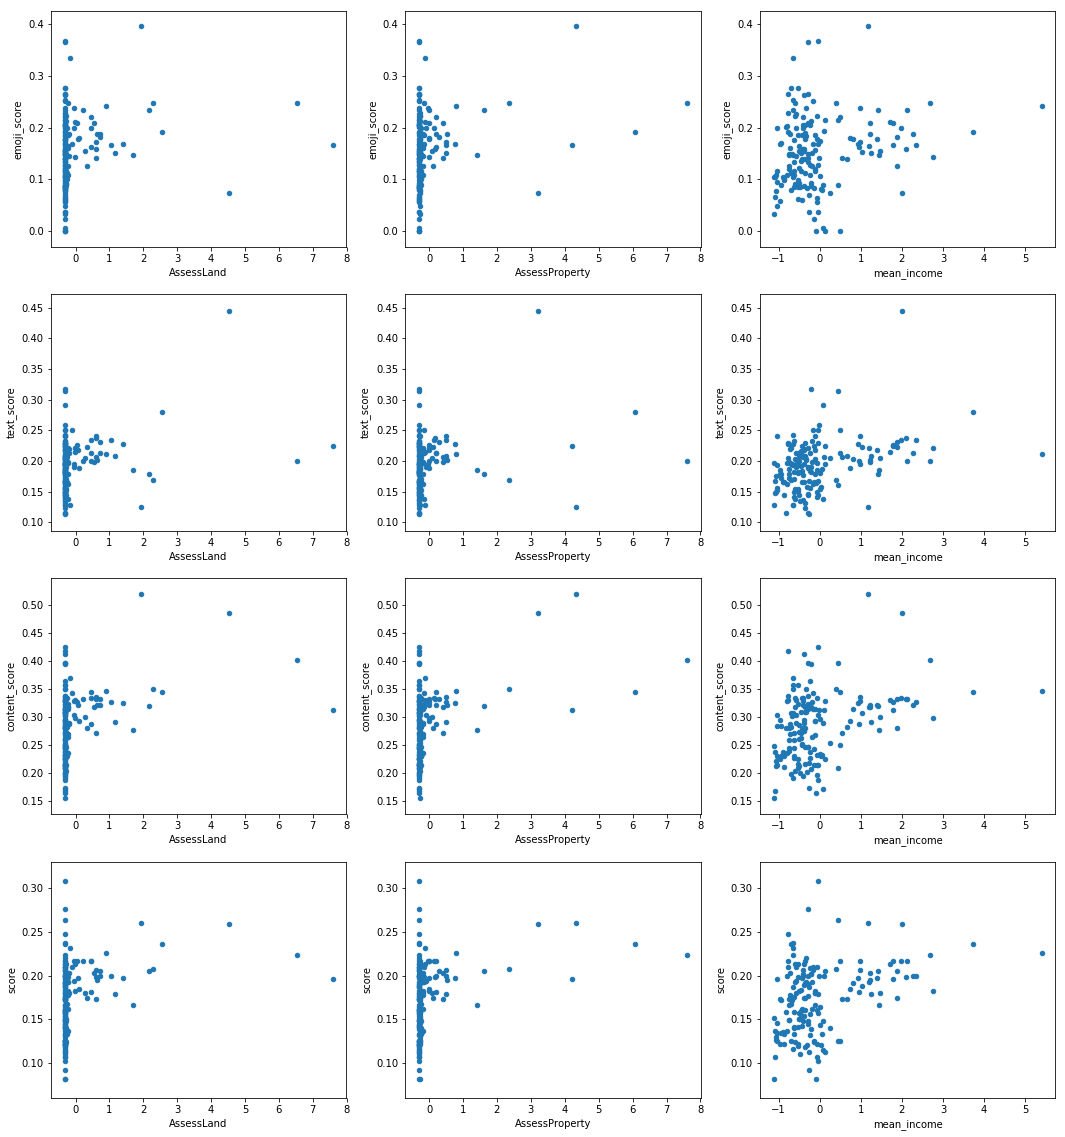

In [145]:
f = plt.figure(figsize=(18, 20))
ax1 = f.add_subplot(431)
ax2 = f.add_subplot(432)
ax3 = f.add_subplot(433)
ax4 = f.add_subplot(434)
ax5 = f.add_subplot(435)
ax6 = f.add_subplot(436)
ax7 = f.add_subplot(437)
ax8 = f.add_subplot(438)
ax9 = f.add_subplot(439)
ax10 = f.add_subplot(4, 3, 10)
ax11 = f.add_subplot(4, 3, 11)
ax12 = f.add_subplot(4, 3, 12)
NYCData.plot(x='AssessLand', y='emoji_score', kind='scatter', ax=ax1)
NYCData.plot(x='AssessProperty', y='emoji_score', kind='scatter', ax=ax2)
NYCData.plot(x='mean_income', y='emoji_score', kind='scatter', ax=ax3)
NYCData.plot(x='AssessLand', y='text_score', kind='scatter', ax=ax4)
NYCData.plot(x='AssessProperty', y='text_score', kind='scatter', ax=ax5)
NYCData.plot(x='mean_income', y='text_score', kind='scatter', ax=ax6)
NYCData.plot(x='AssessLand', y='content_score', kind='scatter', ax=ax7)
NYCData.plot(x='AssessProperty', y='content_score', kind='scatter', ax=ax8)
NYCData.plot(x='mean_income', y='content_score', kind='scatter', ax=ax9)
NYCData.plot(x='AssessLand', y='score', kind='scatter', ax=ax10)
NYCData.plot(x='AssessProperty', y='score', kind='scatter', ax=ax11)
NYCData.plot(x='mean_income', y='score', kind='scatter', ax=ax12)

#### Figure 15: Plots on features and target scores. There're no significant correlations.

In [146]:
x, y = NYCData.iloc[:, :3], NYCData.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=300)

In [147]:
ridge = Ridge(fit_intercept=True, alpha=1, random_state=300)
ridge.fit(X_train, y_train)

# In the sample:
p_IS = ridge.predict(X_train)
err_IS = p_IS - y_train
R_2_IS_Ridge = 1 - np.var(err_IS) / np.var(y_train)
print("The R-squared we found for IS Ridge is: {0}".format(R_2_IS_Ridge))

Ridge_coef = ridge.coef_

# Out of sample
p_OS = ridge.predict(X_test)
err_OS = p_OS - y_test
R_2_OS_Ridge = 1 - np.var(err_OS) / np.var(y_test)
print("The R-squared we found for OS Ridge is: {0}".format(R_2_OS_Ridge))

The R-squared we found for IS Ridge is: 0.16078634738157793
The R-squared we found for OS Ridge is: 0.1288414121539725


In [148]:
lasso = Lasso(fit_intercept=True, alpha=1, random_state=300)
lasso.fit(X_train, y_train)

p_IS = lasso.predict(X_train)
err_IS = p_IS - y_train
R_2_IS_Lasso = 1-np.var(err_IS) / np.var(y_train)
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Lasso))

Lasso_coef = lasso.coef_

#Out of sample
p_OS = lasso.predict(X_test)
err_OS = p_OS - y_test
R_2_OS_Lasso = 1 - np.var(err_OS) / np.var(y_test)
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Lasso is: 0.0
The R-squared we found for OS Lasso is: 1.1102230246251565e-16


In [149]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,alphas,p=0.4,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #lambdas: a list of lambda values to try
    #p: ratio of the validation sample size / total training size
    #Graph: plot the graph of R^2 values for different lambda

    R_2_OS=[]
    X_train0, X_valid, y_train0, y_valid = train_test_split(X_train,
                                    y_train, test_size = 0.4, random_state = 300)

    if model==1:
        RM = lambda a: Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'
    
    best_R2 = -1
    best_alpha = alphas[0]
    
    for i in alphas:
        lm = RM(i)
        lm.fit(X_train0,y_train0)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample 
        err_OS=y_predict-y_valid
        R_2_OS_=1-np.var(err_OS)/np.var(y_valid)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2:
            best_R2 = R_2_OS_
            best_alpha = i
    
    if Graph==True:
        plt.title('OS-R-squared for different Alpha')
        if logl:
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()
    
    return best_alpha

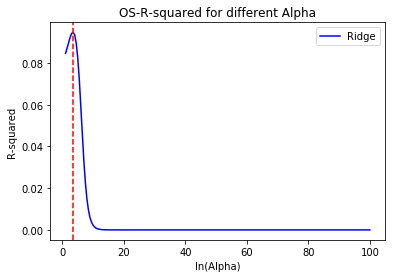

Optimal alpha for Ridge=32.70203099553451


In [150]:
#select best lambda for Ridge
alphas = np.exp(np.linspace(1, 100, 200))
alpha_r_optimal = Regularization_fit_alpha(1, X_train, y_train, alphas, p=0.1, Graph=True, logl=True)
print('Optimal alpha for Ridge={0}'.format(alpha_r_optimal))

In [151]:
ridge = Ridge(fit_intercept=True, alpha=alpha_r_optimal, random_state=300)
ridge.fit(X_train, y_train)

# In the sample:
p_IS = ridge.predict(X_train)
err_IS = p_IS - y_train
R_2_IS_Ridge = 1 - np.var(err_IS) / np.var(y_train)
print("The R-squared we found for IS Ridge is: {0}".format(R_2_IS_Ridge))

Ridge_coef = ridge.coef_
print(Ridge_coef)

# Out of sample
p_OS = ridge.predict(X_test)
err_OS = p_OS - y_test
R_2_OS_Ridge = 1 - np.var(err_OS) / np.var(y_test)
print("The R-squared we found for OS Ridge is: {0}".format(R_2_OS_Ridge))

The R-squared we found for IS Ridge is: 0.15728367561191414
[ 0.00199703  0.00482533  0.00918464]
The R-squared we found for OS Ridge is: 0.12411533057729518


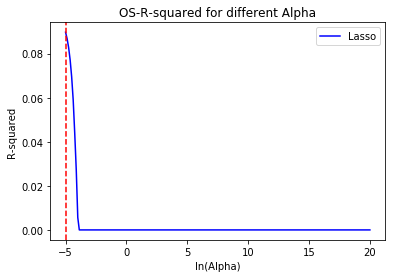

Optimal lambda for Lasso=0.006737946999085467


In [154]:
#select lambdas for Lasso 
alphas = np.exp(np.linspace(-5,20,200))
alpha_l_optimal = Regularization_fit_alpha(2, X_train, y_train, alphas, p=0.1, Graph=True, logl=True)
print('Optimal lambda for Lasso={0}'.format(alpha_l_optimal))

In [155]:
lasso = Lasso(fit_intercept=True, alpha=alpha_l_optimal, random_state=300)
lasso.fit(X_train, y_train)

p_IS = lasso.predict(X_train)
err_IS = p_IS - y_train
R_2_IS_Lasso = 1-np.var(err_IS) / np.var(y_train)
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Lasso))

Lasso_coef = lasso.coef_
print(Lasso_coef)

#Out of sample
p_OS = lasso.predict(X_test)
err_OS = p_OS - y_test
R_2_OS_Lasso = 1 - np.var(err_OS) / np.var(y_test)
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Lasso is: 0.12870516451695013
[ 0.          0.0025754   0.00719622]
The R-squared we found for OS Lasso is: 0.10074253267614286


### 4.2 Discretization

In [156]:
def Discret(score):
    return int(score / 0.05) + 1

NYCData_discret = NYCData
NYCData_discret['content_score_dis'] = NYCData.content_score.map(Discret)
NYCData_discret['text_score_dis'] = NYCData.text_score.map(Discret)
NYCData_discret['emoji_score_dis'] = NYCData.emoji_score.map(Discret)
NYCData_discret['score_dis'] = NYCData.score.map(Discret)
NYCData_discret.head()

AssessLand  AssessProperty  mean_income  content_score  text_score  \
0    0.635338        0.531722     1.222160       0.321180    0.202377   
1   -0.053623       -0.102250    -0.564562       0.302879    0.189755   
2    0.066027        0.006609     1.385603       0.321930    0.218046   
3    7.584219        4.220044     1.775342       0.312889    0.224669   
4    1.694808        1.411083     1.432299       0.277121    0.185994   

   emoji_score     score  content_score_dis  text_score_dis  emoji_score_dis  \
0     0.187339  0.194858                  7               5                4   
1     0.198565  0.194160                  7               4                4   
2     0.177017  0.197532                  7               5                4   
3     0.166850  0.195759                  7               5                4   
4     0.146513  0.166254                  6               4                3   

   score_dis  
0          4  
1          4  
2          4  
3          4  
4          4

In [157]:
NYCData_discret.describe()

AssessLand  AssessProperty   mean_income  content_score  text_score  \
count  165.000000    1.650000e+02  1.650000e+02     165.000000  165.000000   
mean     0.000000    2.153160e-17  4.306320e-17       0.285560    0.193685   
std      1.003044    1.003044e+00  1.003044e+00       0.060606    0.041375   
min     -0.325702   -2.964740e-01 -1.122133e+00       0.154826    0.113472   
25%     -0.320395   -2.929403e-01 -6.172959e-01       0.236729    0.166596   
50%     -0.312147   -2.831337e-01 -2.948344e-01       0.289022    0.195208   
75%     -0.227164   -1.871087e-01  9.280126e-02       0.324462    0.216698   
max      7.584219    7.606159e+00  5.397277e+00       0.520000    0.444853   

       emoji_score       score  content_score_dis  text_score_dis  \
count   165.000000  165.000000         165.000000      165.000000   
mean      0.153724    0.173705           6.193939        4.363636   
std       0.069410    0.040142           1.234153        0.884079   
min       0.000000    0.081711           4.000000        3.000000   
25%       0.105091    0.141447           5.000000        4.000000   
50%       0.152701    0.176967           6.000000        4.000000   
75%       0.198565    0.201671           7.000000        5.000000   
max       0.395000    0.308948          11.000000        9.000000   

       emoji_score_dis   score_dis  
count       165.000000  165.000000  
mean          3.581818    3.963636  
std           1.401535    0.868773  
min           1.000000    2.000000  
25%           3.000000    3.000000  
50%           4.000000    4.000000  
75%           4.000000    5.000000  
max           8.000000    7.000000

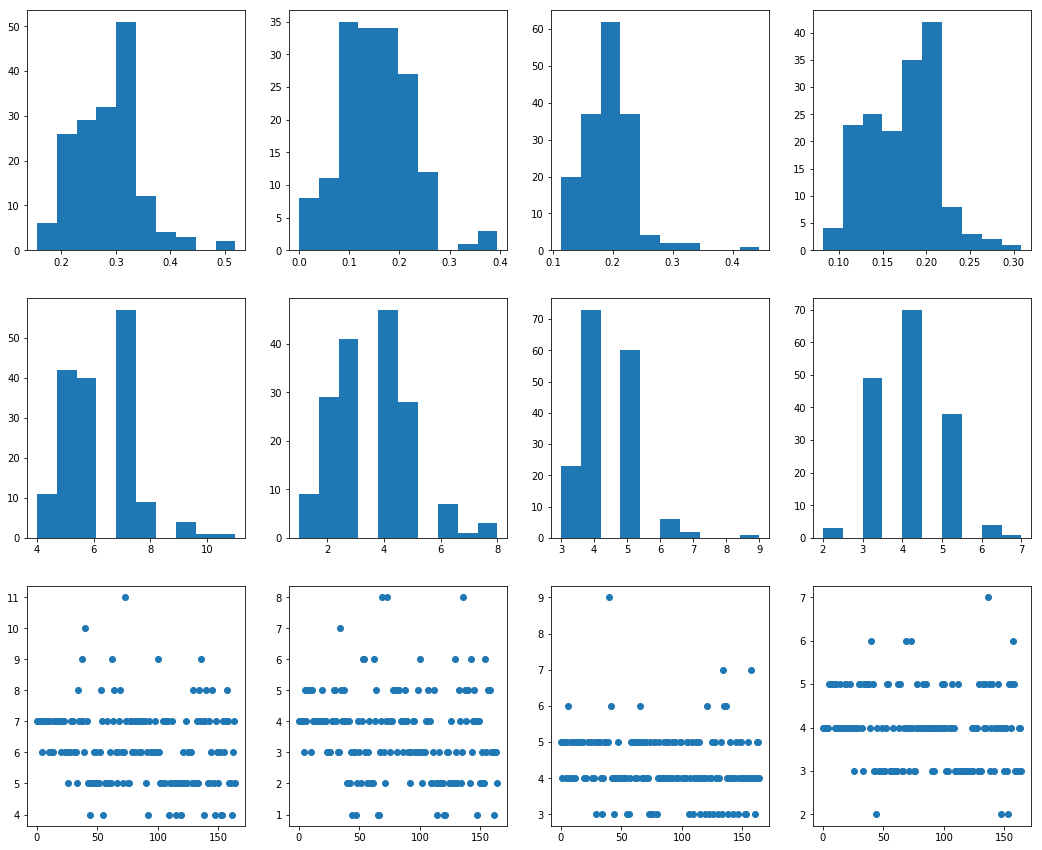

In [158]:
f = plt.figure(figsize=(18, 15))
ax1 = f.add_subplot(341)
ax2 = f.add_subplot(342)
ax3 = f.add_subplot(343)
ax4 = f.add_subplot(344)
ax5 = f.add_subplot(345)
ax6 = f.add_subplot(346)
ax7 = f.add_subplot(347)
ax8 = f.add_subplot(348)
ax9 = f.add_subplot(349)
ax10 = f.add_subplot(3, 4, 10)
ax11 = f.add_subplot(3, 4, 11)
ax12 = f.add_subplot(3, 4, 12)
ax1.hist(NYCData_discret.content_score)
ax2.hist(NYCData_discret.emoji_score)
ax3.hist(NYCData_discret.text_score)
ax4.hist(NYCData_discret.score)
ax5.hist(NYCData_discret.content_score_dis)
ax6.hist(NYCData_discret.emoji_score_dis)
ax7.hist(NYCData_discret.text_score_dis)
ax8.hist(NYCData_discret.score_dis)
ax9.scatter(list(range(NYCData_discret.shape[0])), NYCData_discret.content_score_dis)
ax10.scatter(list(range(NYCData_discret.shape[0])), NYCData_discret.emoji_score_dis)
ax11.scatter(list(range(NYCData_discret.shape[0])), NYCData_discret.text_score_dis)
ax12.scatter(list(range(NYCData_discret.shape[0])), NYCData_discret.score_dis)

#### Figure 16: Plots on discreted target scores.

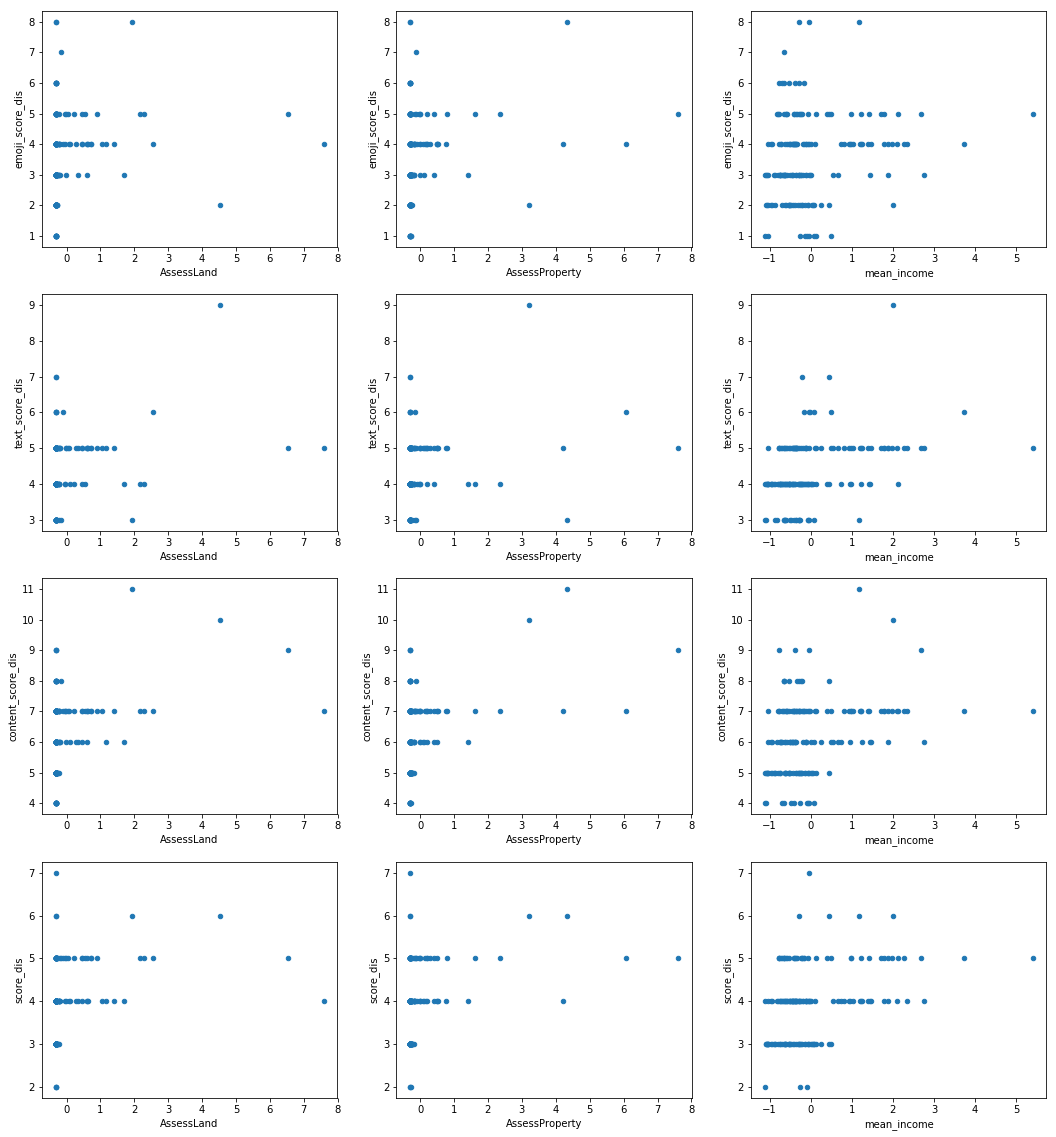

In [159]:
f = plt.figure(figsize=(18, 20))
ax1 = f.add_subplot(431)
ax2 = f.add_subplot(432)
ax3 = f.add_subplot(433)
ax4 = f.add_subplot(434)
ax5 = f.add_subplot(435)
ax6 = f.add_subplot(436)
ax7 = f.add_subplot(437)
ax8 = f.add_subplot(438)
ax9 = f.add_subplot(439)
ax10 = f.add_subplot(4, 3, 10)
ax11 = f.add_subplot(4, 3, 11)
ax12 = f.add_subplot(4, 3, 12)
NYCData.plot(x='AssessLand', y='emoji_score_dis', kind='scatter', ax=ax1)
NYCData.plot(x='AssessProperty', y='emoji_score_dis', kind='scatter', ax=ax2)
NYCData.plot(x='mean_income', y='emoji_score_dis', kind='scatter', ax=ax3)
NYCData.plot(x='AssessLand', y='text_score_dis', kind='scatter', ax=ax4)
NYCData.plot(x='AssessProperty', y='text_score_dis', kind='scatter', ax=ax5)
NYCData.plot(x='mean_income', y='text_score_dis', kind='scatter', ax=ax6)
NYCData.plot(x='AssessLand', y='content_score_dis', kind='scatter', ax=ax7)
NYCData.plot(x='AssessProperty', y='content_score_dis', kind='scatter', ax=ax8)
NYCData.plot(x='mean_income', y='content_score_dis', kind='scatter', ax=ax9)
NYCData.plot(x='AssessLand', y='score_dis', kind='scatter', ax=ax10)
NYCData.plot(x='AssessProperty', y='score_dis', kind='scatter', ax=ax11)
NYCData.plot(x='mean_income', y='score_dis', kind='scatter', ax=ax12)

#### Figure 17: Plots on features and discreted target scores. A little bit more easier to do classification.

In [160]:
x, y = NYCData_discret.iloc[:, :3], NYCData_discret.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=300)

In [161]:
clf = LogisticRegression(C=100000, random_state=300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
cm_precision = cm[1][1] / (cm[1][1] + cm[0][1])
cm_recall = cm[1][1] / cm[1].sum()
clf.coef_, clf.score(X_train, y_train), cm_accuracy, cm_precision, cm_recall

(array([[ -1.02016163e+02,   4.60186744e+01,  -6.17863144e-01],
        [ -9.80982184e+00,  -1.98945552e+00,  -7.22713628e-01],
        [  1.61144350e+00,  -2.32939031e+00,   1.98921391e-01],
        [ -3.34744004e-01,   4.59094773e-01,   4.93788454e-01],
        [  2.42563821e-02,   4.57221950e-01,   4.98489874e-02],
        [ -1.32427580e+02,  -4.69579923e+01,   1.99710966e+00]]),
 0.47972972972972971,
 0.35294117647058826,
 0.7142857142857143,
 0.7142857142857143)

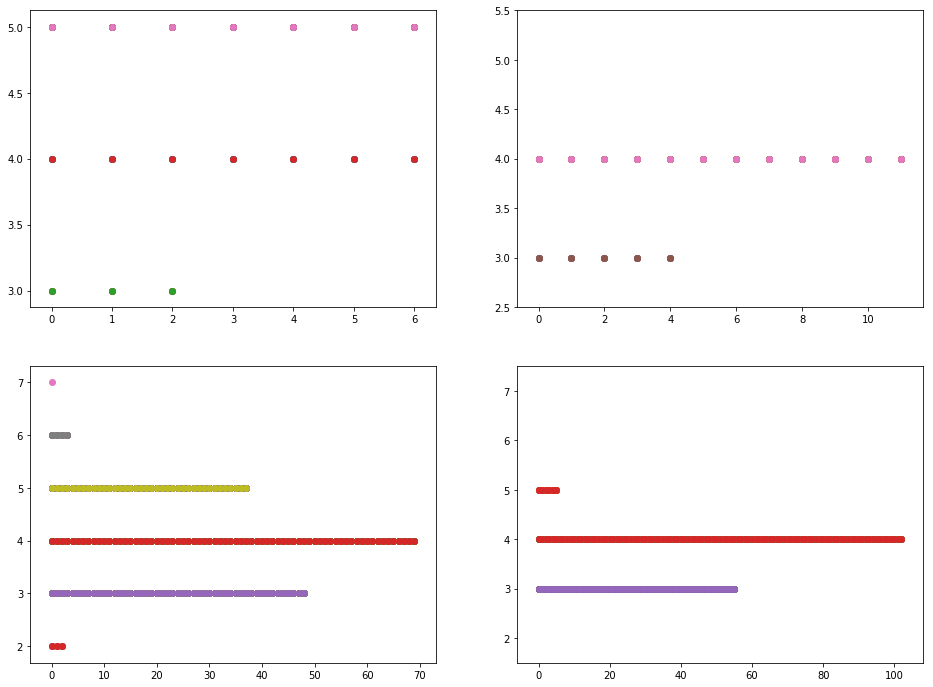

In [162]:
f = plt.figure(figsize=(16, 12))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
for label in y_test.values:
    y_test_label = y_test[y_test.values == label]
    ax1.scatter(list(range(len(y_test_label))), y_test_label)
for label in y_pred:
    y_pred_label = y_pred[y_pred == label]
    ax2.scatter(list(range(len(y_pred_label))), y_pred_label)
    ax2.set_ylim(min(y_test.values) - 0.5, max(y_test.values) + 0.5)
for label in y.values:
    y_label = y[y.values == label]
    ax3.scatter(list(range(len(y_label))), y_label)
x_pred = clf.predict(x)
for label in x_pred:
    x_label = x_pred[x_pred == label]
    ax4.scatter(list(range(len(x_label))), x_label)
    ax4.set_ylim(min(y.values) - 0.5, max(y.values) + 0.5)

#### Figure 18: Classification results on test data and all data

### 4.3 ACS features
- There're more than 540 economics indexs in the ACS data. We hope to filter out some most important features later
- Download data here: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_17_5YR_DP03&prodType=table

In [163]:
NYeco_dict = {k: v['Id'] for k, v in 
              pd.read_csv('Data/ACS_17_5YR_DP03_metadata.csv').set_index('GEO.id').T.to_dict().items()}
NYeco_dict

{'GEO.display-label': 'Geography',
 'GEO.id2': 'Id2',
 'HC01_VC03': 'Estimate; EMPLOYMENT STATUS - Population 16 years and over',
 'HC01_VC04': 'Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force',
 'HC01_VC05': 'Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force',
 'HC01_VC06': 'Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force - Employed',
 'HC01_VC07': 'Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Civilian labor force - Unemployed',
 'HC01_VC08': 'Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force - Armed Forces',
 'HC01_VC09': 'Estimate; EMPLOYMENT STATUS - Population 16 years and over - Not in labor force',
 'HC01_VC100': 'Estimate; INCOME AND BENEFITS (IN 2017 INFLATION-ADJUSTED DOLLARS) - With cash public assistance income - Mean cash public assistance income (dollars)',
 'HC01_VC101': 'Estimate; INCOM

In [164]:
NYeco = pd.read_csv('Data/ACS_17_5YR_DP03.csv').drop(columns=['GEO.id', 'GEO.display-label'])
NYeco.head()

GEO.id2  HC01_VC03  HC02_VC03  HC03_VC03  HC04_VC03  HC01_VC04  HC02_VC04  \
0     6390        185        110        185        NaN        152        100   
1     7421       5988        392       5988        NaN       4385        347   
2    10001      21565       1061      21565        NaN      15255        924   
3    10002      68698       1747      68698        NaN      37185       1548   
4    10003      51685       1586      51685        NaN      34697       1420   

   HC03_VC04  HC04_VC04  HC01_VC05     ...      HC03_VC178  HC04_VC178  \
0       82.2       13.3        152     ...             0.0        39.1   
1       73.2        3.9       4385     ...             9.2         7.5   
2       70.7        2.5      15255     ...            14.4         4.5   
3       54.1        1.7      37185     ...            32.5         3.5   
4       67.1        1.8      34690     ...             9.4         4.2   

   HC01_VC179  HC02_VC179  HC03_VC179  HC04_VC179  HC01_VC180  HC02_VC180  \
0         NaN         NaN         0.9         2.6         NaN         NaN   
1         NaN         NaN         7.3         5.2         NaN         NaN   
2         NaN         NaN        20.1        11.3         NaN         NaN   
3         NaN         NaN        25.5         3.2         NaN         NaN   
4         NaN         NaN         2.2         1.1         NaN         NaN   

   HC03_VC180  HC04_VC180  
0         0.0        76.1  
1        13.4         8.5  
2        16.6         2.9  
3        32.1         2.6  
4        13.6         2.0  

[5 rows x 549 columns]

In [165]:
NYCeco = NYCzip.merge(NYeco, left_on='zipcode', right_on='GEO.id2')
NYCeco.head()

zipcode                                           geometry  GEO.id2  \
0  11372.0  POLYGON Z ((-73.86942457284175 40.749156870967...    11372   
1  11004.0  POLYGON Z ((-73.71068374074007 40.750040394509...    11004   
2  11040.0  POLYGON Z ((-73.70098278625547 40.738895699230...    11040   
3  11426.0  POLYGON Z ((-73.72270447144122 40.753733714383...    11426   
4  11365.0  POLYGON Z ((-73.81088634744755 40.727171875759...    11365   

   HC01_VC03  HC02_VC03  HC03_VC03  HC04_VC03  HC01_VC04  HC02_VC04  \
0      53683       1778      53683        NaN      35067       1468   
1      12884        723      12884        NaN       7833        644   
2      34378        792      34378        NaN      21799        744   
3      17183        960      17183        NaN      11176        699   
4      37154       1215      37154        NaN      23395       1090   

   HC03_VC04     ...      HC03_VC178  HC04_VC178  HC01_VC179  HC02_VC179  \
0       65.3     ...            19.9         4.2         NaN         NaN   
1       60.8     ...             6.0         3.3         NaN         NaN   
2       63.4     ...             2.7         1.1         NaN         NaN   
3       65.0     ...             7.8         3.3         NaN         NaN   
4       63.0     ...             9.4         3.8         NaN         NaN   

   HC03_VC179  HC04_VC179  HC01_VC180  HC02_VC180  HC03_VC180  HC04_VC180  
0        11.5         2.3         NaN         NaN        20.8         2.6  
1         4.2         3.3         NaN         NaN        16.7         6.4  
2         2.5         1.1         NaN         NaN        20.5         6.6  
3         7.3         2.3         NaN         NaN        20.6         4.8  
4        11.8         3.1         NaN         NaN        21.6         4.1  

[5 rows x 551 columns]

In [166]:
NYCeco.describe()

zipcode       GEO.id2     HC01_VC03    HC02_VC03     HC03_VC03  \
count    222.000000    222.000000    222.000000   222.000000    222.000000   
mean   10753.373874  10753.373874  32484.666667  1102.792793  32484.666667   
std      585.545999    585.545999  23900.798082   602.352291  23900.798082   
min    10001.000000  10001.000000      0.000000    11.000000      0.000000   
25%    10156.000000  10156.000000  11858.500000   731.250000  11858.500000   
50%    10474.500000  10474.500000  29858.000000  1185.000000  29858.000000   
75%    11356.750000  11356.750000  52316.500000  1565.500000  52316.500000   
max    11697.000000  11697.000000  86579.000000  2381.000000  86579.000000   

       HC04_VC03     HC01_VC04    HC02_VC04   HC03_VC04   HC04_VC04  \
count        0.0    222.000000   222.000000  196.000000  196.000000   
mean         NaN  20618.581081   930.319820   64.403061    2.435204   
std          NaN  15142.590349   524.704641    8.552726    1.799868   
min          NaN      0.000000    11.000000   17.600000    1.000000   
25%          NaN   7052.750000   619.250000   59.300000    1.600000   
50%          NaN  18910.500000   946.500000   64.000000    2.000000   
75%          NaN  34519.250000  1331.500000   68.825000    2.600000   
max          NaN  57684.000000  2202.000000   89.700000   18.900000   

          ...      HC03_VC178  HC04_VC178  HC01_VC179  HC02_VC179  HC03_VC179  \
count     ...      195.000000  195.000000         0.0         0.0  195.000000   
mean      ...       17.684103    4.817949         NaN         NaN   14.325641   
std       ...       11.243926    5.396766         NaN         NaN   10.294106   
min       ...        0.000000    1.100000         NaN         NaN    0.000000   
25%       ...        9.350000    2.900000         NaN         NaN    6.900000   
50%       ...       14.500000    3.600000         NaN         NaN   11.900000   
75%       ...       24.800000    5.250000         NaN         NaN   20.450000   
max       ...       62.500000   58.300000         NaN         NaN   45.400000   

       HC04_VC179  HC01_VC180  HC02_VC180  HC03_VC180  HC04_VC180  
count  195.000000         0.0         0.0  196.000000  196.000000  
mean     2.913333         NaN         NaN   25.793367    4.167347  
std      1.556770         NaN         NaN   11.748013    2.237571  
min      0.400000         NaN         NaN    0.000000    1.400000  
25%      2.000000         NaN         NaN   17.575000    2.800000  
50%      2.600000         NaN         NaN   24.600000    3.600000  
75%      3.450000         NaN         NaN   33.275000    4.800000  
max     11.300000         NaN         NaN   78.100000   21.800000  

[8 rows x 550 columns]

In [167]:
NYCDat = NYCeco.merge(NYCtweets.groupby('zipcode').mean()[['content_score', 'text_score', 
                                                           'emoji_score', 'score']].reset_index())
NYCDat.drop(columns=['GEO.id2', 'zipcode', 'geometry'], inplace=True)
NYCDat.head()

HC01_VC03  HC02_VC03  HC03_VC03  HC04_VC03  HC01_VC04  HC02_VC04  \
0      53683       1778      53683        NaN      35067       1468   
1      12884        723      12884        NaN       7833        644   
2      17183        960      17183        NaN      11176        699   
3      37154       1215      37154        NaN      23395       1090   
4      79774       2196      79774        NaN      52025       1857   

   HC03_VC04  HC04_VC04  HC01_VC05  HC02_VC05    ...     HC03_VC179  \
0       65.3        2.0      35067       1468    ...           11.5   
1       60.8        3.7       7833        644    ...            4.2   
2       65.0        2.7      11176        699    ...            7.3   
3       63.0        2.1      23395       1090    ...           11.8   
4       65.2        1.2      52017       1853    ...           15.2   

   HC04_VC179  HC01_VC180  HC02_VC180  HC03_VC180  HC04_VC180  content_score  \
0         2.3         NaN         NaN        20.8         2.6       0.274109   
1         3.3         NaN         NaN        16.7         6.4       0.225000   
2         2.3         NaN         NaN        20.6         4.8       0.232456   
3         3.1         NaN         NaN        21.6         4.1       0.218081   
4         1.9         NaN         NaN        30.6         2.6       0.259544   

   text_score  emoji_score     score  
0    0.207095     0.093605  0.150350  
1    0.225000     0.000000  0.112500  
2    0.141827     0.178564  0.160196  
3    0.188852     0.037321  0.113086  
4    0.141636     0.175861  0.158749  

[5 rows x 552 columns]

In [168]:
min([c for c in NYCDat.describe().iloc[0, :].tolist() if c!= 0])

161.0

In [169]:
NYCDat_count = NYCDat.describe().iloc[0, :].tolist()
NYCDat_drop = []
for count_index in range(len(NYCDat_count)):
    if NYCDat_count[count_index] < 161:
        NYCDat_drop.append(NYCDat.columns[count_index])
NYCDat.drop(columns=NYCDat_drop, inplace=True)
NYCDat.describe()

HC01_VC03    HC02_VC03     HC03_VC03     HC01_VC04    HC02_VC04  \
count    199.000000   199.000000    199.000000    199.000000   199.000000   
mean   33984.718593  1149.160804  33984.718593  21661.788945   969.854271   
std    23945.063710   593.340521  23945.063710  15186.580129   519.930759   
min        0.000000    11.000000      0.000000      0.000000    11.000000   
25%    15214.000000   781.000000  15214.000000   8897.000000   628.500000   
50%    31387.000000  1226.000000  31387.000000  20441.000000  1007.000000   
75%    53440.500000  1582.000000  53440.500000  34882.000000  1414.000000   
max    86579.000000  2381.000000  86579.000000  57684.000000  2202.000000   

        HC03_VC04   HC04_VC04     HC01_VC05    HC02_VC05   HC03_VC05  \
count  179.000000  179.000000    199.000000   199.000000  179.000000   
mean    64.683799    2.375419  21651.386935   969.839196   64.651397   
std      8.669047    1.688114  15180.092598   519.603252    8.671167   
min     17.600000    1.000000      0.000000    11.000000   17.600000   
25%     59.700000    1.600000   8876.000000   629.000000   59.700000   
50%     64.500000    1.900000  20399.000000  1006.000000   64.500000   
75%     69.400000    2.550000  34852.500000  1414.000000   69.350000   
max     89.700000   18.900000  57684.000000  2200.000000   89.700000   

          ...      HC03_VC178  HC04_VC178  HC03_VC179  HC04_VC179  HC03_VC180  \
count     ...      178.000000  178.000000  178.000000  178.000000  179.000000   
mean      ...       18.295506    4.842697   14.642697    2.894382   25.848045   
std       ...       11.468482    5.594315   10.500679    1.560773   11.934975   
min       ...        0.000000    1.200000    0.000000    0.400000    5.900000   
25%       ...        9.400000    2.900000    6.925000    2.000000   16.950000   
50%       ...       14.850000    3.600000   11.900000    2.600000   24.600000   
75%       ...       25.300000    5.200000   21.175000    3.400000   33.400000   
max       ...       62.500000   58.300000   45.400000   11.300000   78.100000   

       HC04_VC180  content_score  text_score  emoji_score       score  
count  179.000000     199.000000  199.000000   199.000000  199.000000  
mean     3.992179       0.286099    0.191501     0.159184    0.175343  
std      2.159678       0.076445    0.054660     0.096539    0.054748  
min      1.400000       0.125000    0.000000     0.000000    0.062500  
25%      2.800000       0.230707    0.162362     0.098568    0.135988  
50%      3.400000       0.287885    0.190316     0.152701    0.176967  
75%      4.500000       0.326956    0.213305     0.203618    0.203470  
max     21.800000       0.704000    0.562500     0.704000    0.489250  

[8 rows x 461 columns]

In [170]:
NYCDat.dropna(inplace=True)
NYCDat.head()

HC01_VC03  HC02_VC03  HC03_VC03  HC01_VC04  HC02_VC04  HC03_VC04  \
0      53683       1778      53683      35067       1468       65.3   
1      12884        723      12884       7833        644       60.8   
3      37154       1215      37154      23395       1090       63.0   
4      79774       2196      79774      52025       1857       65.2   
5      22797        716      22797      14713        575       64.5   

   HC04_VC04  HC01_VC05  HC02_VC05  HC03_VC05    ...     HC03_VC178  \
0        2.0      35067       1468       65.3    ...           19.9   
1        3.7       7833        644       60.8    ...            6.0   
3        2.1      23395       1090       63.0    ...            9.4   
4        1.2      52017       1853       65.2    ...           17.4   
5        1.5      14703        578       64.5    ...            2.5   

   HC04_VC178  HC03_VC179  HC04_VC179  HC03_VC180  HC04_VC180  content_score  \
0         4.2        11.5         2.3        20.8         2.6       0.274109   
1         3.3         4.2         3.3        16.7         6.4       0.225000   
3         3.8        11.8         3.1        21.6         4.1       0.218081   
4         2.9        15.2         1.9        30.6         2.6       0.259544   
5         1.2         2.5         1.1        11.6         3.1       0.250000   

   text_score  emoji_score     score  
0    0.207095     0.093605  0.150350  
1    0.225000     0.000000  0.112500  
3    0.188852     0.037321  0.113086  
4    0.141636     0.175861  0.158749  
5    0.250000     0.000000  0.125000  

[5 rows x 461 columns]

In [171]:
NYCDat.iloc[:, :-4] = scale(NYCDat.iloc[:, :-4], axis=0)
NYCDat.head()

HC01_VC03  HC02_VC03  HC03_VC03  HC01_VC04  HC02_VC04  HC03_VC04  \
0   0.583602   0.979417   0.583602   0.656026   0.807237   0.235883   
1  -1.463032  -1.584565  -1.463032  -1.491064  -1.359062  -0.449219   
3  -0.245556  -0.388850  -0.245556  -0.264178  -0.186526  -0.114280   
4   1.892426   1.995288   1.892426   1.992971   1.829920   0.220659   
5  -0.965758  -1.601577  -0.965758  -0.948654  -1.540463   0.114087   

   HC04_VC04  HC01_VC05  HC02_VC05  HC03_VC05    ...     HC03_VC178  \
0   0.013883   0.657292   0.808460   0.241548    ...       0.096395   
1   2.344511  -1.490564  -1.361030  -0.443770    ...      -1.265919   
3   0.150979  -0.263241  -0.186768  -0.108726    ...      -0.932691   
4  -1.082883   1.994082   1.822117   0.226319    ...      -0.148625   
5  -0.671596  -0.948750  -1.534800   0.119714    ...      -1.608948   

   HC04_VC178  HC03_VC179  HC04_VC179  HC03_VC180  HC04_VC180  content_score  \
0    0.156911   -0.428256   -0.403116   -0.595182   -0.702449       0.274109   
1   -0.392665   -1.136123    0.488933   -0.977644    1.938444       0.225000   
3   -0.087345   -0.399165    0.310523   -0.520556    0.340008       0.218081   
4   -0.636921   -0.069473   -0.759935    0.318993   -0.702449       0.259544   
5   -1.675009   -1.300969   -1.473575   -1.453388   -0.354963       0.250000   

   text_score  emoji_score     score  
0    0.207095     0.093605  0.150350  
1    0.225000     0.000000  0.112500  
3    0.188852     0.037321  0.113086  
4    0.141636     0.175861  0.158749  
5    0.250000     0.000000  0.125000  

[5 rows x 461 columns]

In [172]:
# Use PCA to do dimensionality reduction

n = 5
pca = PCA(n_components=n, whiten=True)
pca.fit(NYCDat.iloc[:, :-4]) #fit the model to the data
NYCDat_pca = pca.transform(NYCDat.iloc[:, :-4]) #transform the data to principal components
NYCDat_pca.shape

(158, 5)

Text(0.5,1,'The explained variance of leading components')

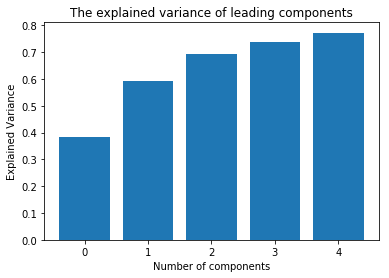

In [173]:
eigenvalues = pca.explained_variance_ratio_
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.title("The explained variance of leading components")

In [174]:
x, y = pd.DataFrame(NYCDat_pca), NYCDat.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=300)

In [175]:
ridge = Ridge(fit_intercept=True, alpha=1, random_state=300)
ridge.fit(X_train, y_train)

# In the sample:
p_IS = ridge.predict(X_train)
err_IS = p_IS - y_train
R_2_IS_Ridge = 1 - np.var(err_IS) / np.var(y_train)
print("The R-squared we found for IS Ridge is: {0}".format(R_2_IS_Ridge))

Ridge_coef = ridge.coef_

# Out of sample
p_OS = ridge.predict(X_test)
err_OS = p_OS - y_test
R_2_OS_Ridge = 1 - np.var(err_OS) / np.var(y_test)
print("The R-squared we found for OS Ridge is: {0}".format(R_2_OS_Ridge))

The R-squared we found for IS Ridge is: 0.1778034276192677
[-0.00216058  0.01360676  0.00498832 -0.00194259  0.00118647]
The R-squared we found for OS Ridge is: 0.10975936910714257


In [176]:
lasso = Lasso(fit_intercept=True, alpha=1, random_state=300)
lasso.fit(X_train, y_train)

p_IS = lasso.predict(X_train)
err_IS = p_IS - y_train
R_2_IS_Lasso = 1-np.var(err_IS) / np.var(y_train)
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Lasso))

Lasso_coef = lasso.coef_

#Out of sample
p_OS = lasso.predict(X_test)
err_OS = p_OS - y_test
R_2_OS_Lasso = 1 - np.var(err_OS) / np.var(y_test)
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Lasso is: 0.0
The R-squared we found for OS Lasso is: 0.0


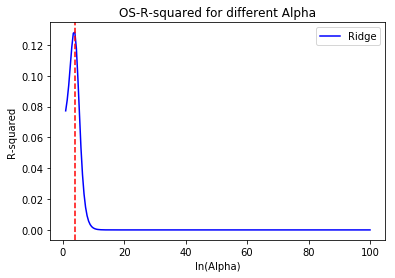

Optimal alpha for Ridge=53.78123546313257


In [177]:
#select best lambda for Ridge
alphas = np.exp(np.linspace(1, 100, 200))
alpha_r_optimal = Regularization_fit_alpha(1, X_train, y_train, alphas, p=0.1, Graph=True, logl=True)
print('Optimal alpha for Ridge={0}'.format(alpha_r_optimal))

In [178]:
ridge = Ridge(fit_intercept=True, alpha=alpha_r_optimal, random_state=300) # try Ridge with an arbitrary regularization parameter alpha=1
ridge.fit(X_train, y_train)

# In the sample:
p_IS = ridge.predict(X_train)
err_IS = p_IS - y_train
R_2_IS_Ridge = 1 - np.var(err_IS) / np.var(y_train)
print("The R-squared we found for IS Ridge is: {0}".format(R_2_IS_Ridge))

Ridge_coef = ridge.coef_
print(Ridge_coef)

# Out of sample
p_OS = ridge.predict(X_test)
err_OS = p_OS - y_test
R_2_OS_Ridge = 1 - np.var(err_OS) / np.var(y_test)
print("The R-squared we found for OS Ridge is: {0}".format(R_2_OS_Ridge))

The R-squared we found for IS Ridge is: 0.16502414757106365
[-0.00162335  0.01003399  0.00367435 -0.00131978  0.00087292]
The R-squared we found for OS Ridge is: 0.09241911932976632


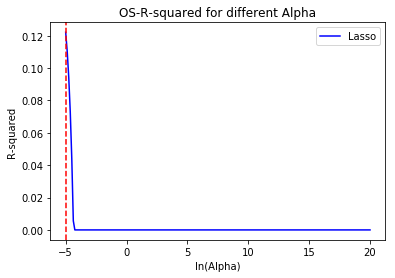

Optimal lambda for Lasso=0.006737946999085467


In [179]:
#select lambdas for Lasso 
alphas = np.exp(np.linspace(-5,20,200))
alpha_l_optimal = Regularization_fit_alpha(2, X_train, y_train, alphas, p=0.1, Graph=True, logl=True)
print('Optimal lambda for Lasso={0}'.format(alpha_l_optimal))

In [180]:
lasso = Lasso(fit_intercept=True, alpha=alpha_l_optimal, random_state=300)
lasso.fit(X_train, y_train)

p_IS = lasso.predict(X_train)
err_IS = p_IS - y_train
R_2_IS_Lasso = 1-np.var(err_IS) / np.var(y_train)
print("The R-squared we found for IS Lasso is: {0}".format(R_2_IS_Lasso))

Lasso_coef = lasso.coef_
print(Lasso_coef)

#Out of sample
p_OS = lasso.predict(X_test)
err_OS = p_OS - y_test
R_2_OS_Lasso = 1 - np.var(err_OS) / np.var(y_test)
print("The R-squared we found for OS Lasso is: {0}".format(R_2_OS_Lasso))

The R-squared we found for IS Lasso is: 0.1161393277485433
[-0.          0.00718036  0.         -0.          0.        ]
The R-squared we found for OS Lasso is: 0.05912613037043968


### 4.4 Repeat Discretization

In [181]:
def Discret(score):
    return int(score / 0.05) + 1

NYCDat_discret = NYCDat
NYCDat_discret['content_score_dis'] = NYCDat.content_score.map(Discret)
NYCDat_discret['text_score_dis'] = NYCDat.text_score.map(Discret)
NYCDat_discret['emoji_score_dis'] = NYCDat.emoji_score.map(Discret)
NYCDat_discret['score_dis'] = NYCDat.score.map(Discret)
NYCDat_discret.head()

HC01_VC03  HC02_VC03  HC03_VC03  HC01_VC04  HC02_VC04  HC03_VC04  \
0   0.583602   0.979417   0.583602   0.656026   0.807237   0.235883   
1  -1.463032  -1.584565  -1.463032  -1.491064  -1.359062  -0.449219   
3  -0.245556  -0.388850  -0.245556  -0.264178  -0.186526  -0.114280   
4   1.892426   1.995288   1.892426   1.992971   1.829920   0.220659   
5  -0.965758  -1.601577  -0.965758  -0.948654  -1.540463   0.114087   

   HC04_VC04  HC01_VC05  HC02_VC05  HC03_VC05    ...      HC03_VC180  \
0   0.013883   0.657292   0.808460   0.241548    ...       -0.595182   
1   2.344511  -1.490564  -1.361030  -0.443770    ...       -0.977644   
3   0.150979  -0.263241  -0.186768  -0.108726    ...       -0.520556   
4  -1.082883   1.994082   1.822117   0.226319    ...        0.318993   
5  -0.671596  -0.948750  -1.534800   0.119714    ...       -1.453388   

   HC04_VC180  content_score  text_score  emoji_score     score  \
0   -0.702449       0.274109    0.207095     0.093605  0.150350   
1    1.938444       0.225000    0.225000     0.000000  0.112500   
3    0.340008       0.218081    0.188852     0.037321  0.113086   
4   -0.702449       0.259544    0.141636     0.175861  0.158749   
5   -0.354963       0.250000    0.250000     0.000000  0.125000   

   content_score_dis  text_score_dis  emoji_score_dis  score_dis  
0                  6               5                2          4  
1                  5               5                1          3  
3                  5               4                1          3  
4                  6               3                4          4  
5                  6               6                1          3  

[5 rows x 465 columns]

In [182]:
NYCDat.describe()

HC01_VC03   HC02_VC03     HC03_VC03     HC01_VC04     HC02_VC04  \
count  1.580000e+02  158.000000  1.580000e+02  1.580000e+02  1.580000e+02   
mean  -1.349132e-16    0.000000 -1.349132e-16 -8.432074e-17 -2.473408e-16   
std    1.003180e+00    1.003180  1.003180e+00  1.003180e+00  1.003180e+00   
min   -1.659874e+00   -1.992858 -1.659874e+00 -1.750521e+00 -2.008426e+00   
25%   -7.549318e-01   -0.707221 -7.549318e-01 -7.925735e-01 -7.662214e-01   
50%   -2.358493e-01   -0.002430 -2.358493e-01 -1.535277e-01 -1.037125e-01   
75%    7.699602e-01    0.614869  7.699602e-01  7.824834e-01  7.756891e-01   
max    2.233790e+00    2.444896  2.233790e+00  2.439119e+00  2.736926e+00   

          HC03_VC04     HC04_VC04     HC01_VC05     HC02_VC05     HC03_VC05  \
count  1.580000e+02  1.580000e+02  1.580000e+02  1.580000e+02  1.580000e+02   
mean   1.663929e-15  7.869935e-17 -1.180490e-16  3.035546e-16  9.668778e-16   
std    1.003180e+00  1.003180e+00  1.003180e+00  1.003180e+00  1.003180e+00   
min   -2.641546e+00 -1.357075e+00 -1.750115e+00 -2.011351e+00 -2.636790e+00   
25%   -6.585558e-01 -6.715957e-01 -7.920615e-01 -7.673167e-01 -6.531733e-01   
50%    7.515890e-03 -2.603084e-01 -1.525512e-01 -1.011991e-01  1.310877e-02   
75%    5.974651e-01  2.880746e-01  7.832614e-01  7.768650e-01  5.918224e-01   
max    2.473884e+00  3.989660e+00  2.441020e+00  2.735725e+00  2.480256e+00   

          ...        HC03_VC180    HC04_VC180  content_score  text_score  \
count     ...      1.580000e+02  1.580000e+02     158.000000  158.000000   
mean      ...      8.994212e-17 -1.461559e-16       0.279256    0.190842   
std       ...      1.003180e+00  1.003180e+00       0.054455    0.034943   
min       ...     -1.798536e+00 -1.536416e+00       0.154826    0.113472   
25%       ...     -7.211147e-01 -6.329522e-01       0.231883    0.165896   
50%       ...     -1.241021e-01 -2.507177e-01       0.284300    0.194662   
75%       ...      6.897940e-01  3.226341e-01       0.321721    0.215014   
max       ...      2.958908e+00  4.370845e+00       0.424318    0.318129   

       emoji_score       score  content_score_dis  text_score_dis  \
count   158.000000  158.000000         158.000000      158.000000   
mean      0.148677    0.169759           6.075949        4.310127   
std       0.065948    0.038269           1.114721        0.772966   
min       0.000000    0.081711           4.000000        3.000000   
25%       0.101815    0.138696           5.000000        4.000000   
50%       0.149469    0.173555           6.000000        4.000000   
75%       0.189075    0.199272           7.000000        5.000000   
max       0.367152    0.308948           9.000000        7.000000   

       emoji_score_dis   score_dis  
count       158.000000  158.000000  
mean          3.493671    3.873418  
std           1.353207    0.827352  
min           1.000000    2.000000  
25%           3.000000    3.000000  
50%           3.000000    4.000000  
75%           4.000000    4.000000  
max           8.000000    7.000000  

[8 rows x 465 columns]

In [183]:
x, y = pd.DataFrame(NYCDat_pca), NYCDat_discret.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=300)

In [184]:
clf = LogisticRegression(C=100000, random_state=300).fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
cm_precision = cm[1][1] / (cm[1][1] + cm[0][1])
cm_recall = cm[1][1] / cm[1].sum()
clf.score(X_train, y_train), cm_accuracy, cm_precision, cm_recall

(0.55633802816901412, 0.1875, 0.75, 0.5)

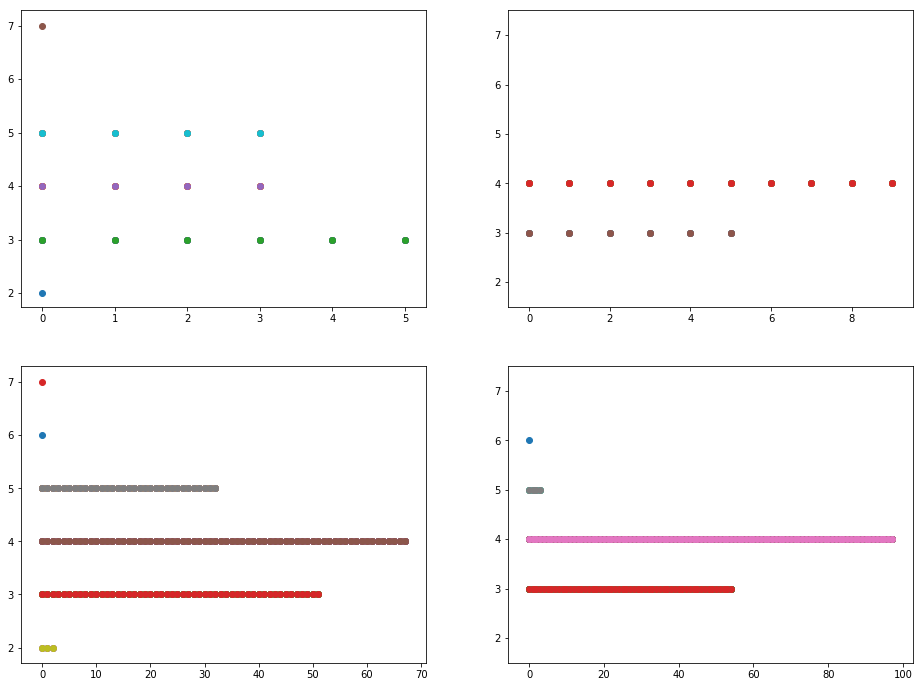

In [185]:
f = plt.figure(figsize=(16, 12))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
for label in y_test.values:
    y_test_label = y_test[y_test.values == label]
    ax1.scatter(list(range(len(y_test_label))), y_test_label)
for label in y_pred:
    y_pred_label = y_pred[y_pred == label]
    ax2.scatter(list(range(len(y_pred_label))), y_pred_label)
    ax2.set_ylim(min(y_test.values) - 0.5, max(y_test.values) + 0.5)
for label in y.values:
    y_label = y[y.values == label]
    ax3.scatter(list(range(len(y_label))), y_label)
x_pred = clf.predict(x)
for label in x_pred:
    x_label = x_pred[x_pred == label]
    ax4.scatter(list(range(len(x_label))), x_label)
    ax4.set_ylim(min(y.values) - 0.5, max(y.values) + 0.5)

#### Figure 19: Classification results on test data and all data